In [1]:
cd /data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved

/data/a/cpac/isultan/projects/halomassloss/core_catalog_mevolved


In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
import subhalo_mass_loss_model_ALCC as SHMLM_HM
import subhalo_mass_loss_model_LJDS as SHMLM_SV
import subhalo_mass_loss_model as SHMLM_AQ
import genericio as gio
from tqdm import tqdm
from itk import hist, h5_read_dict, gio_read_dict, loadpickle, plt_latex, periodic_bcs, many_to_one, reldif, nratioerr
# from cc_generate_fitting_dt_ALCC import m_evolved_col, A_arr, zeta_arr
from scipy import spatial #KD Tree for subhalo-core matching
# from scipy.stats import norm # Gaussian fitting
import itertools as it
# massbinsize = 0.5

In [3]:
assert SHMLM_HM.PARTICLES100MASS/100. * 2000 < 10**12
assert SHMLM_SV.PARTICLES100MASS/100. * 70 < 10**12

In [4]:
AFID, ZETAFID = 1.1, 0.1
A_arr = [0.4, 0.5, 0.6 , 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4]
zeta_arr = [0.001, 0.005, 0.01, 0.02, 0.04, 0.07, 0.08, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]

In [5]:
PARTICLEMASS = {'HM':SHMLM_HM.PARTICLES100MASS/100., 'SV':SHMLM_SV.PARTICLES100MASS/100., 'AQ':SHMLM_AQ.PARTICLES100MASS/100.}
OBJECTMASSCUT = {'HM':SHMLM_HM.PARTICLES100MASS, 'SV':SHMLM_SV.PARTICLES100MASS, 'AQ':SHMLM_AQ.PARTICLES100MASS}
SUBHALOMINMASS = { 'HM':20.*SHMLM_HM.PARTICLES100MASS/100., 'SV':20.*SHMLM_SV.PARTICLES100MASS/100. }
SUBHALOMINCOUNT = { 'HM':20, 'SV':20 }

In [6]:
execfile('paper2plotscripts.py')

In [7]:
(cc_HM0, sh_HM0, centrals_mask_HM0), (cc_SV0, sh_SV0, centrals_mask_SV0),(cc_AQ0, sh_AQ0, centrals_mask_AQ0) = load_data(499)
(cc_HM1, sh_HM1, centrals_mask_HM1), (cc_SV1, sh_SV1, centrals_mask_SV1),(cc_AQ1, sh_AQ1, centrals_mask_AQ1) = load_data(247)

99.9999972959
99.99999751


In [8]:
plt.style.use(['science', 'high-vis'])

# z=0

NameError: name 'cc_HM' is not defined

/home/isultan/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


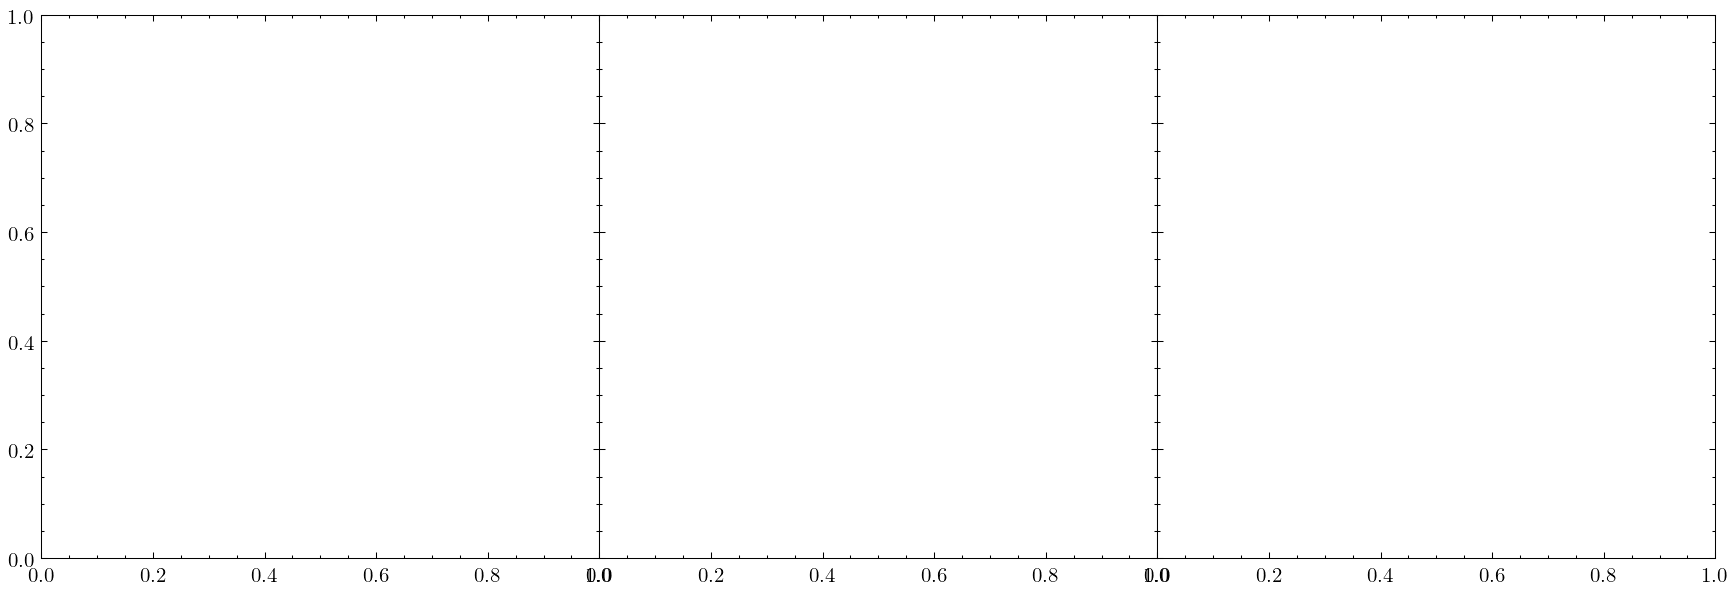

In [15]:
r = (-4,0)
bins = 40
alpha = .8

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=[4.8*3,4.8*1], dpi=150)
for M1, ax in zip((12, 13, 14), (ax1, ax2, ax3)):
    M1, M2 = 10**M1, 10**(M1+0.5)

    for cc, sh, centrals_mask, label in zip([cc_HM, cc_SV], [sh_HM, sh_SV], [centrals_mask_HM, centrals_mask_SV], ['HM', 'SV']):
        bin_mask = (~centrals_mask)&(M1 <= cc['M'])&(cc['M'] <= M2)
        nH = np.sum( ((M1 <= cc['M'])&(cc['M'] <= M2))[centrals_mask] )
        print nH
        parr = cc['m_evolved_0.9_0.001'][bin_mask] / cc['M'][bin_mask]

        x, y, yerr, yerr_log = hist(np.log10(parr), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH, normBinsize=True, normLogCnts=True, retEbars=True)
        ax.errorbar(x, y, yerr=yerr_log, label='cores '+label, marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )

        bin_mask_sh = (sh['subhalo_tag']!=0)&(M1 <= sh['M'])&(sh['M'] <= M2)
        nH_sh = len(np.unique( sh['fof_halo_tag'][(M1 <= sh['M'])&(sh['M'] <= M2)] ))
        print nH_sh
        print ''

        parr_sh = sh['subhalo_mass'][bin_mask_sh] / sh['M'][bin_mask_sh]
        x, y, yerr, yerr_log = hist(np.log10(parr_sh), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH_sh, normBinsize=True, normLogCnts=True, retEbars=True)
        ax.errorbar(x, y, yerr=yerr_log, label='sh '+label, marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )
    ax3.legend()

HM 39505
HM 39505



/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


SV 40628
SV 40628

HM 4738
HM 4738

SV 4797
SV 4797

HM 348
HM 348

SV 337
SV 337



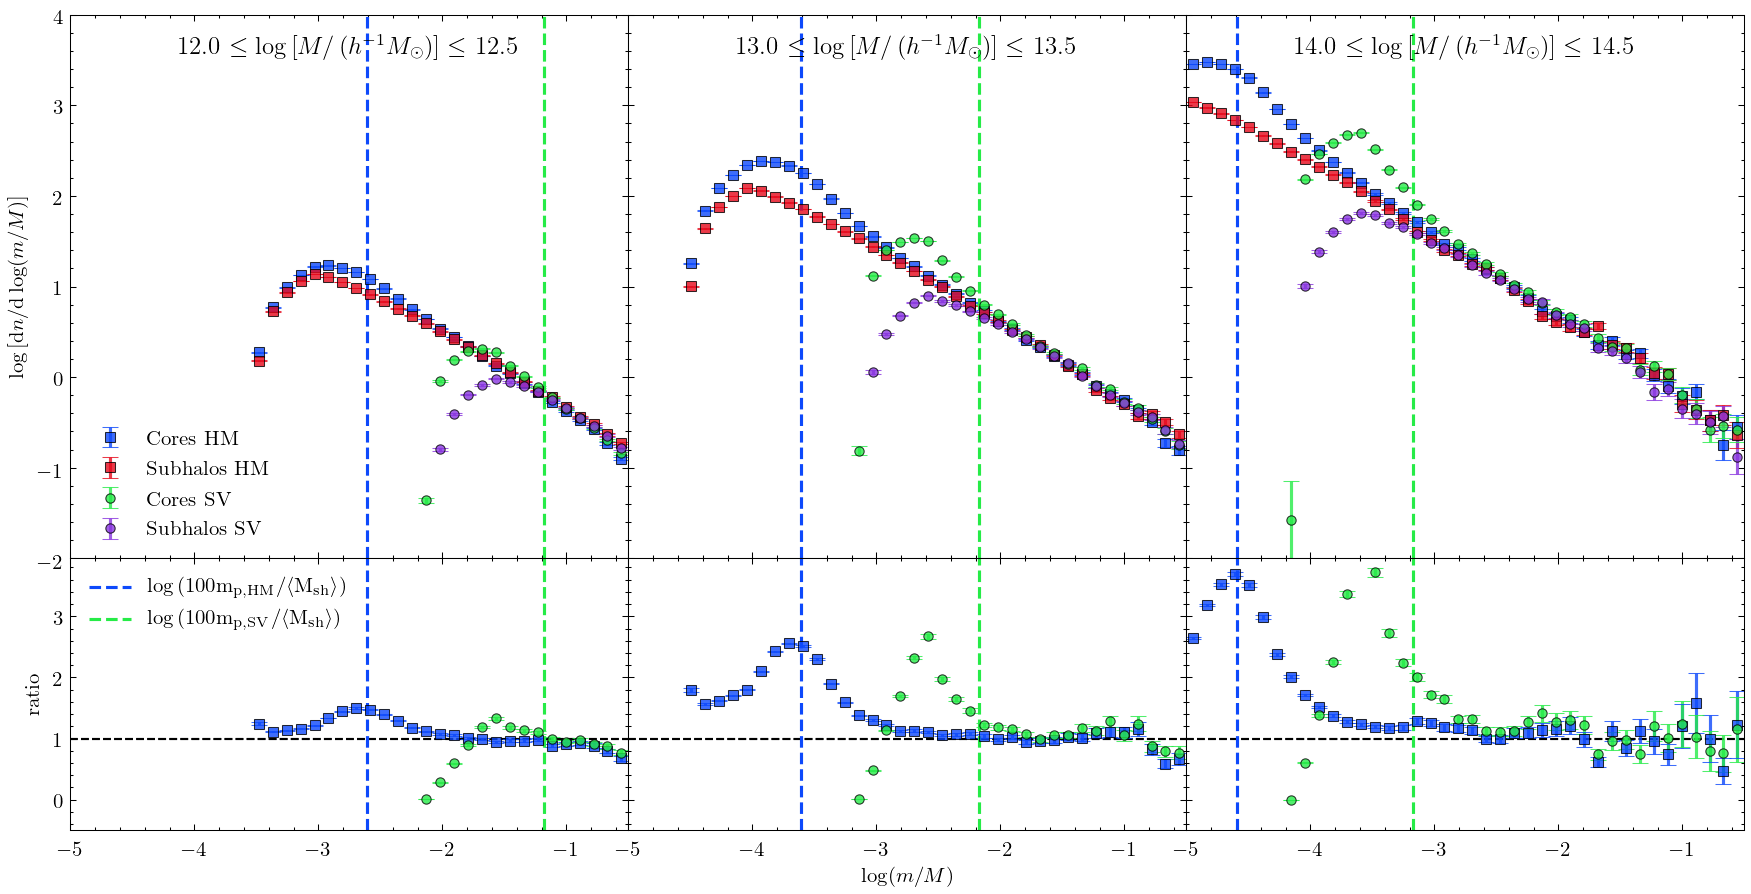

In [11]:
resolution_tests(cc_HM0, sh_HM0, centrals_mask_HM0, cc_SV0, sh_SV0, centrals_mask_SV0)
# plt.savefig('Paper2Figs/resolution_test_z0_mcut_vl.pdf')

SV 40628
SV 40628

AlphaQ 37182
AlphaQ 37181



/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract


SV 4797
SV 4797

AlphaQ 4335
AlphaQ 4335

SV 337
SV 337

AlphaQ 286
AlphaQ 286



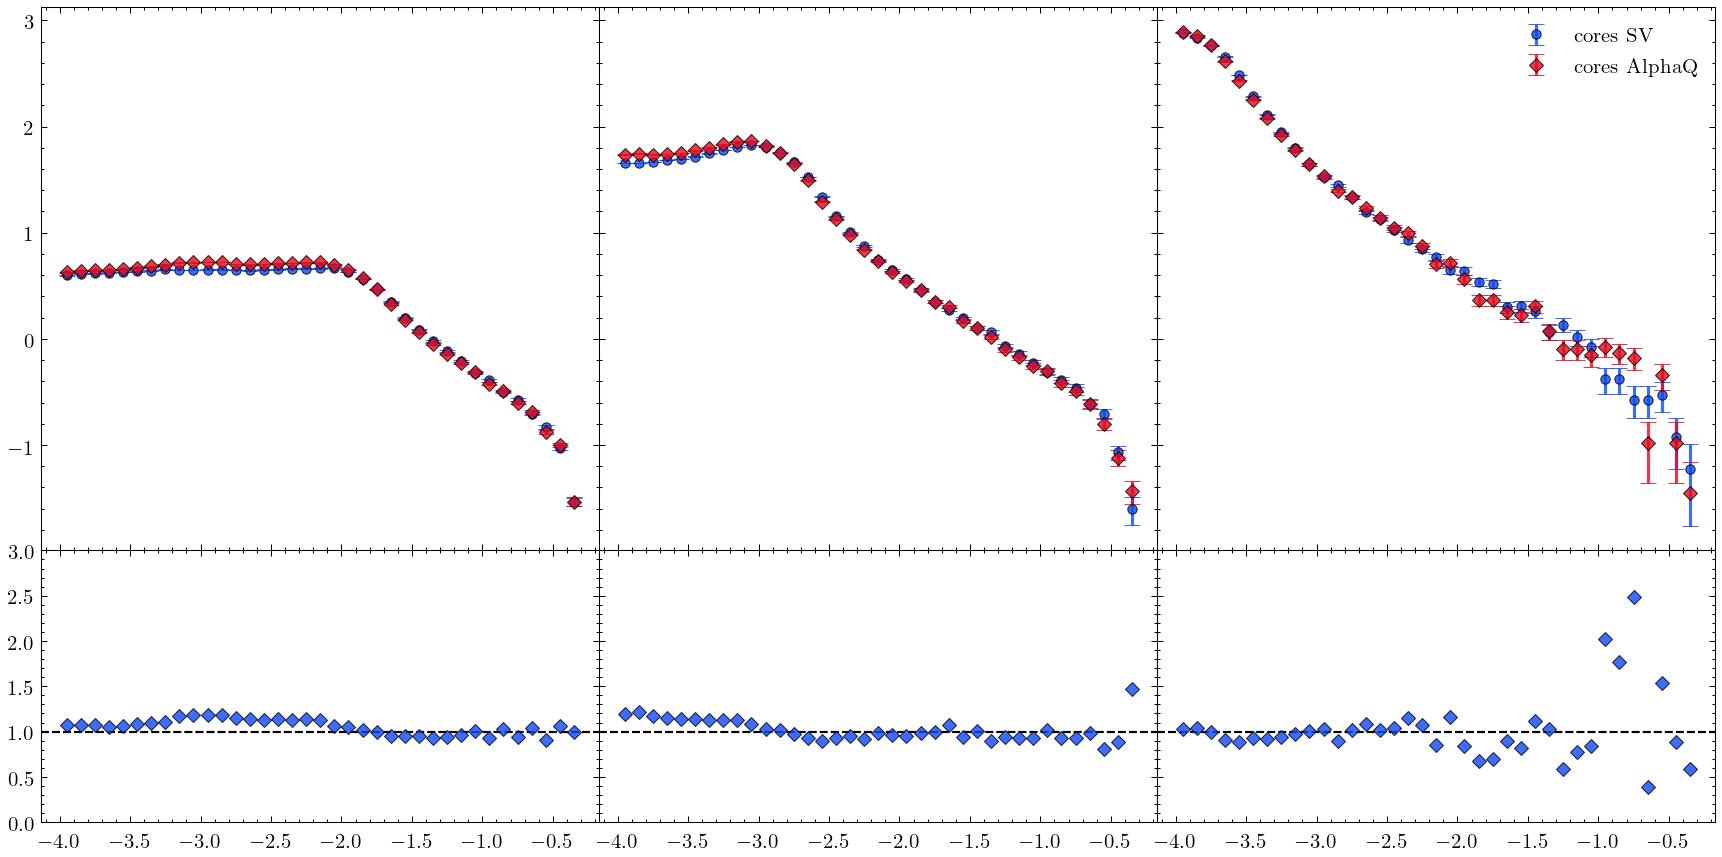

In [25]:
r = (-4,0)
bins = 40
alpha = .8

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='all', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8*3,4.8*1.5], dpi=150)
for logM1, ax, axr in zip((12, 13, 14), (ax1, ax2, ax3), (ax4, ax5, ax6)):
    yfid = 'SV'
    M1, M2 = 10**logM1, 10**(logM1+0.5)

    for cc, sh, centrals_mask, label, marker in zip([cc_SV, cc_AQ], [sh_SV, sh_AQ], [centrals_mask_SV, centrals_mask_AQ], ['SV', 'AlphaQ'], ['o', 'D']):
        bin_mask = (~centrals_mask)&(M1 <= cc['M'])&(cc['M'] <= M2)
        
        fht_fof = (cc['fof_halo_tag']<0)*np.bitwise_and(cc['fof_halo_tag']*-1, 0xffffffffffff) + (cc['fof_halo_tag']>=0)*cc['fof_halo_tag']
        nH_cores = len(np.unique( fht_fof[centrals_mask&(M1 <= cc['M'])&(cc['M'] <= M2)] ))
        print label, nH_cores
        parr = cc['m_evolved_0.9_0.001'][bin_mask] / cc['M'][bin_mask]

        x, y, yerr, yerr_log = hist(np.log10(parr), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH_cores, normBinsize=True, normLogCnts=True, retEbars=True)
        ax.errorbar(x, y, yerr=yerr_log, label='cores '+label, marker=marker, ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )

        bin_mask_sh = (sh['subhalo_tag']!=0)&(M1 <= sh['M'])&(sh['M'] <= M2)
        nH_sh = len(np.unique( sh['fof_halo_tag'][(M1 <= sh['M'])&(sh['M'] <= M2)] ))
        print label, nH_sh
        print ''
#         assert nH_cores == nH_sh

        parr_sh = sh['subhalo_mass'][bin_mask_sh] / sh['M'][bin_mask_sh]
        x_sh, y_sh, yerr_sh, yerr_log_sh = hist(np.log10(parr_sh), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH_sh, normBinsize=True, normLogCnts=True, retEbars=True)
        if yfid == label:
            yfid = y
#         ax.errorbar(x_sh, y_sh, yerr=yerr_log_sh, label='sh '+label, marker=marker, ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )
        else:
            axr.errorbar(x, 10**(y-yfid), yerr=None, marker=marker, ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )
        axr.axhline(1, c='k',ls='--', lw=1, zorder=-1)
        axr.set_ylim(0,3)
ax3.legend()
# plt.savefig('Paper2Figs/cosmology_test_z0.pdf')

SV 40628

AlphaQ 37182

(0.8293575094459665, 1.1931324774146645)


/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:162: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in subtract


SV 4797

AlphaQ 4335

(0.6844205034749176, 2.314062440064772)
SV 337

AlphaQ 286

(-0.2690717094287717, 2.737466627832455)


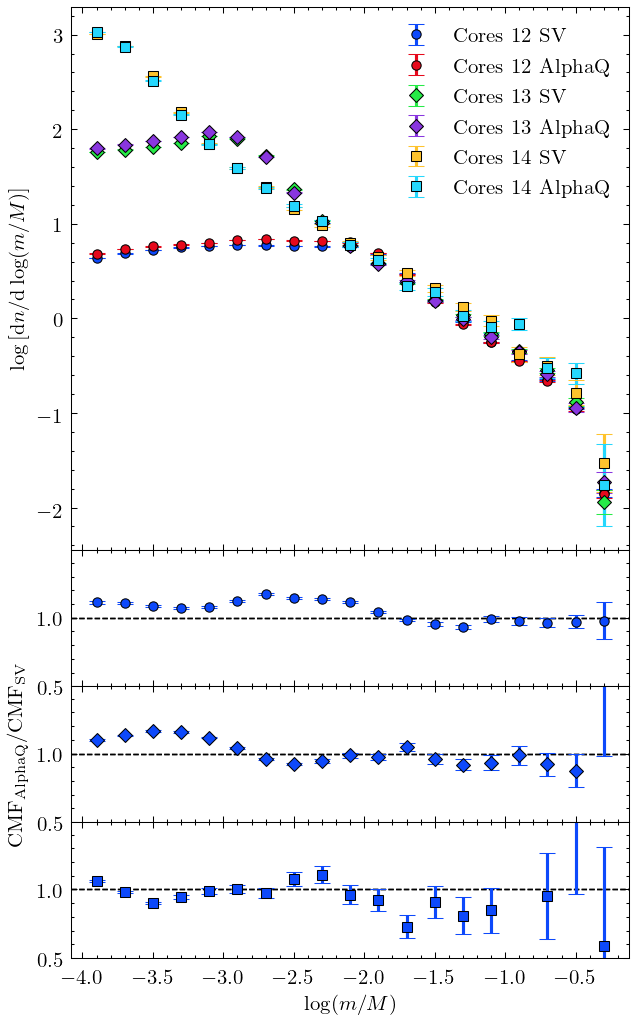

In [12]:
execfile('paper2plotscripts.py')
cosmology_tests(cc_SV0, centrals_mask_SV0, cc_AQ0, centrals_mask_AQ0)
# plt.savefig('Paper2Figs/cosmology_test_z0.pdf')

HM 39505
SV 40628
HM 4738
SV 4797
HM 348
SV 337


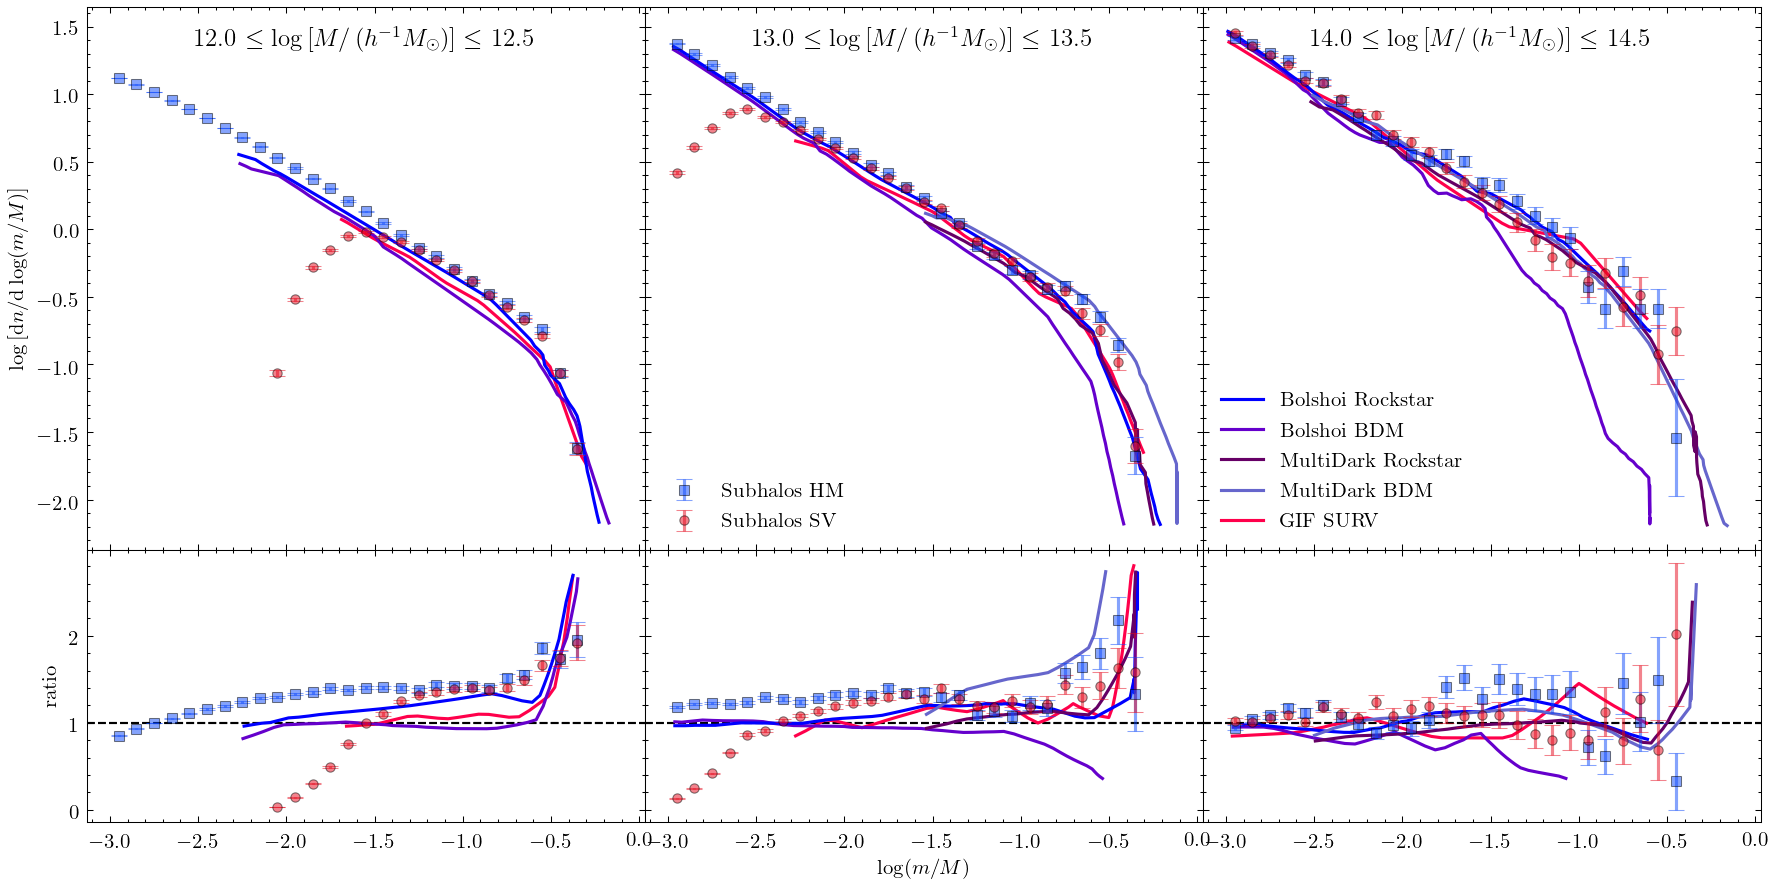

In [32]:
r = (-3,0)
bins = 30
alpha = .5

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='all', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0, 'height_ratios': [2, 1]}, figsize=[4.8*3,4.8*1.5], dpi=150)
fig5_plot(None, ax3, legendFlag=True)
ax3.legend(loc=3)
for logM1, ax, axr in zip((12, 13, 14), (ax1, ax2, ax3), (ax4, ax5, ax6)):
    M1, M2 = 10**logM1, 10**(logM1+0.5)
    ax.set_title(r'{} $\le \log \left[ M / \left(h^{{-1}}M_\odot \right) \right] \le$ {}'.format(logM1+0.0, logM1+0.5), y=0.9)

    for sh, label, marker in zip([sh_HM0, sh_SV0], ['HM', 'SV'], ['s', 'o']):
        x, y, yerr, yerr_log, nH_sh = subhalo_plot(sh, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label])

        errorbar(ax, x, y, yerr=yerr_log, label='Subhalos '+label, marker=marker, alpha=alpha)
        errorbar(axr, x, 10**(y-fitting_model(x, logM1)), yerr=yerr/10**fitting_model(x, logM1), marker=marker, alpha=alpha, zerocut=True)
        
        axr.axhline(1, c='k',ls='--', lw='1', zorder=-2)
#         axr.set_ylim(10**(-0.4),10**0.4)
    if ax == ax2:
        ax.legend(loc=3)
    fig5_plot(logM1, ax)
    fig5_plot(logM1, axr, ratioFlag=True)
ax5.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
ax4.set_ylabel(r'ratio')
# plt.savefig('Paper2Figs/subfinder_comparison_mcut.pdf')

# z=1

30462
33020

33812
34592

2078
2368

2246
2418

18
21

29
36



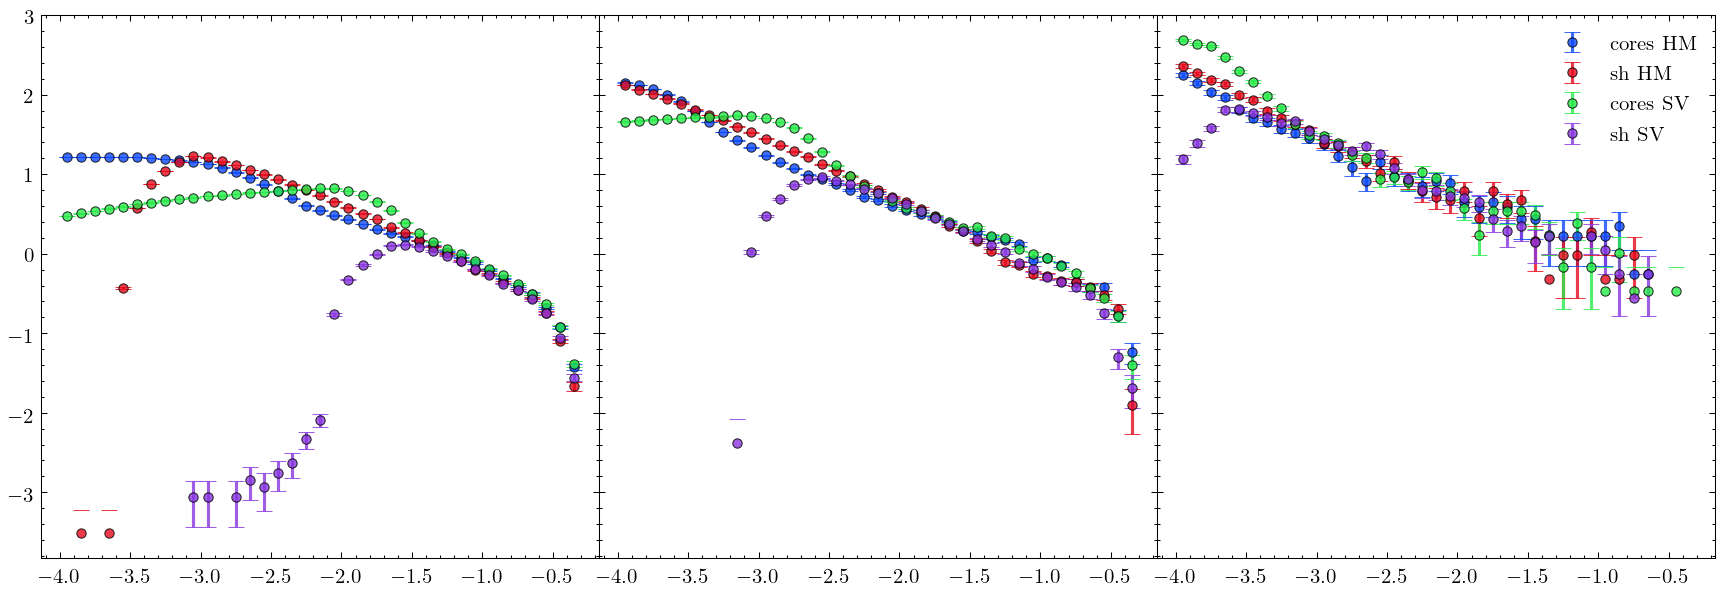

In [15]:
r = (-4,0)
bins = 40
alpha = .8

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=[4.8*3,4.8*1], dpi=150)
for M1, ax in zip((12, 13, 14), (ax1, ax2, ax3)):
    M1, M2 = 10**M1, 10**(M1+0.5)

    for cc, sh, centrals_mask, label in zip([cc_HM, cc_SV], [sh_HM, sh_SV], [centrals_mask_HM, centrals_mask_SV], ['HM', 'SV']):
        bin_mask = (~centrals_mask)&(M1 <= cc['M'])&(cc['M'] <= M2)
        nH = np.sum( ((M1 <= cc['M'])&(cc['M'] <= M2))[centrals_mask] )
        print nH
        parr = cc['m_evolved_0.9_0.001'][bin_mask] / cc['M'][bin_mask]

        x, y, yerr, yerr_log = hist(np.log10(parr), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH, normBinsize=True, normLogCnts=True, retEbars=True)
        ax.errorbar(x, y, yerr=yerr_log, label='cores '+label, marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )

        bin_mask_sh = (sh['subhalo_tag']!=0)&(M1 <= sh['M'])&(sh['M'] <= M2)
        nH_sh = len(np.unique( sh['fof_halo_tag'][(M1 <= sh['M'])&(sh['M'] <= M2)] ))
        print nH_sh
        print ''

        parr_sh = sh['subhalo_mass'][bin_mask_sh] / sh['M'][bin_mask_sh]
        x, y, yerr, yerr_log = hist(np.log10(parr_sh), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH_sh, normBinsize=True, normLogCnts=True, retEbars=True)
        ax.errorbar(x, y, yerr=yerr_log, label='sh '+label, marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )
    ax3.legend()

33020
33020

34592
34592

2368
2368

2418
2418

21
21

36
36



/home/isultan/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


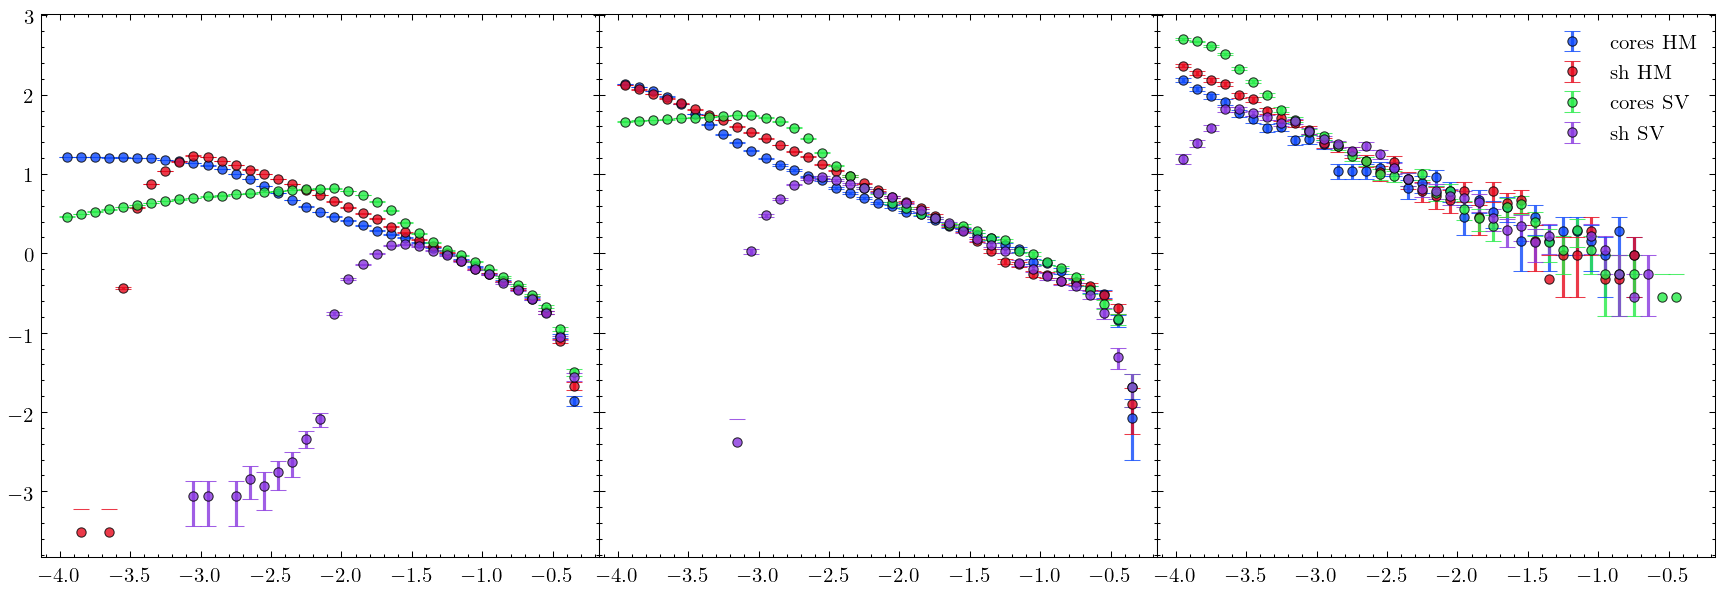

In [25]:
r = (-4,0)
bins = 40
alpha = .8

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=[4.8*3,4.8*1], dpi=150)
for M1, ax in zip((12, 13, 14), (ax1, ax2, ax3)):
    M1, M2 = 10**M1, 10**(M1+0.5)

    for cc, sh, centrals_mask, label in zip([cc_HM, cc_SV], [sh_HM, sh_SV], [centrals_mask_HM, centrals_mask_SV], ['HM', 'SV']):
        bin_mask = (~centrals_mask)&(M1 <= cc['M'])&(cc['M'] <= M2)
        
        fht_fof = (cc['fof_halo_tag']<0)*np.bitwise_and(cc['fof_halo_tag']*-1, 0xffffffffffff) + (cc['fof_halo_tag']>=0)*cc['fof_halo_tag']
        nH_cores = len(np.unique( fht_fof[centrals_mask&(M1 <= cc['M'])&(cc['M'] <= M2)] ))
        print nH_cores
        parr = cc['m_evolved_0.9_0.001'][bin_mask] / cc['M'][bin_mask]

        x, y, yerr, yerr_log = hist(np.log10(parr), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH_cores, normBinsize=True, normLogCnts=True, retEbars=True)
        ax.errorbar(x, y, yerr=yerr_log, label='cores '+label, marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )

        bin_mask_sh = (sh['subhalo_tag']!=0)&(M1 <= sh['M'])&(sh['M'] <= M2)
        nH_sh = len(np.unique( sh['fof_halo_tag'][(M1 <= sh['M'])&(sh['M'] <= M2)] ))
        print nH_sh
        print ''
        assert nH_cores == nH_sh

        parr_sh = sh['subhalo_mass'][bin_mask_sh] / sh['M'][bin_mask_sh]
        x, y, yerr, yerr_log = hist(np.log10(parr_sh), bins=bins, normed=True, plotFlag=False, range=r, normScalar=nH_sh, normBinsize=True, normLogCnts=True, retEbars=True)
        ax.errorbar(x, y, yerr=yerr_log, label='sh '+label, marker='o', ls='', mec='k', alpha=alpha, mew=0.5, ms=20**0.5, capsize=4, elinewidth=1.5 )
    ax3.legend()

HM 33020
HM 33020

SV 34592


/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


SV 34592

HM 2368
HM 2368

SV 2418
SV 2418

HM 21
HM 21

SV 36
SV 36



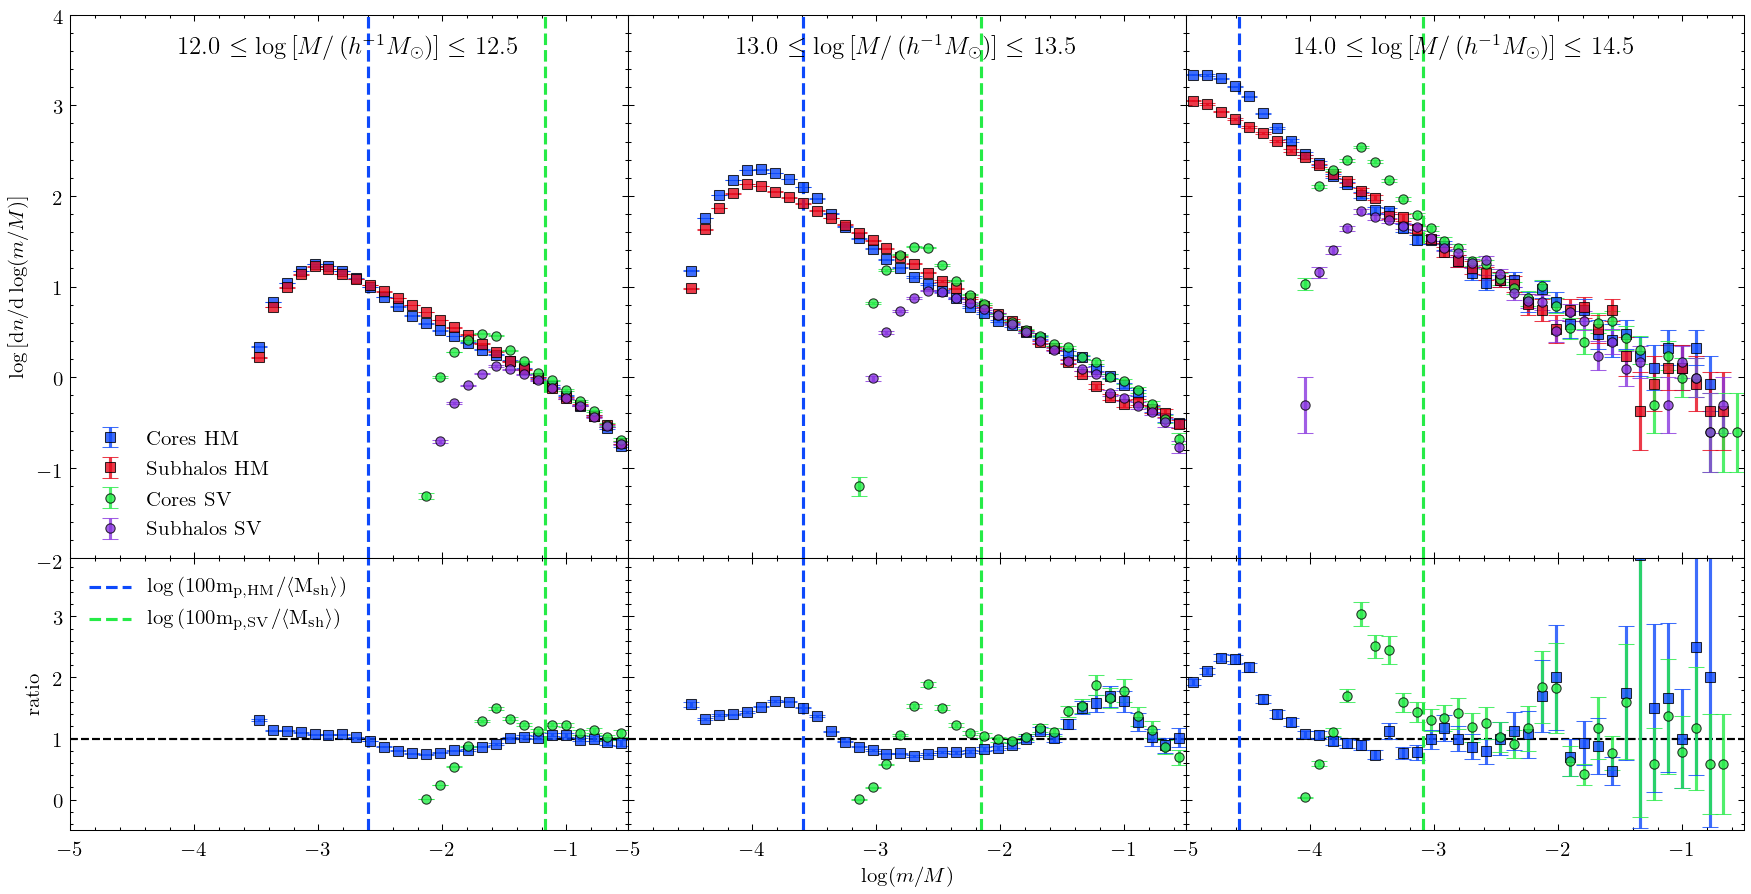

In [121]:
resolution_tests(cc_HM1, sh_HM1, centrals_mask_HM1, cc_SV1, sh_SV1, centrals_mask_SV1)
# plt.savefig('Paper2Figs/resolution_test_z1_mcut_vl.pdf')

# fig 5 comparison

In [28]:
fig5 = loadpickle("Notebooks/2016bfig5.p")

In [29]:
def fig5_plot(logM1, ax, ratioFlag=False, legendFlag=False, excludelabels=['HS Subfind', 'MSII Subfind']):
    colorsd = {'MSII Subfind':'#983334', 'HS Subfind':'#FF9833', 'GIF SURV':'#FF004B', 'Bolshoi BDM':'#6500CC', 'Bolshoi Rockstar':'#0000FF', 'MultiDark BDM':'#6666CC', 'MultiDark Rockstar':'#660066'}
    """Plot 2016B Figure 5 plot of M range [M1, M1+0.5]."""
    if legendFlag:
        for label, c in colorsd.items():
            if label in excludelabels:
                continue
            ax.plot([], [], '-', label=label, alpha=1., c=c)
        return
    for label, x, y, xlr, ylr in fig5[logM1]:
        if label in excludelabels:
            continue
        if ratioFlag:
            ax.plot(xlr, 10**ylr, '-', label=label, alpha=1., c=colorsd[label], zorder=-1)
#             ax.plot(x, 10**(y-fitting_model(x, logM1)), '--', label=label, alpha=1., c=colorsd[label])
        else:
            ax.plot(x, y, '-', label=label, alpha=1., c=colorsd[label], zorder=-1)

In [30]:
def fitting_model(log_m_over_M, logM1):
    Amd = {12:0.045, 13:0.058, 14:0.080}
    Am, alpha = Amd[logM1], 0.86
    psi = 10**log_m_over_M
    return np.log10( Am * psi**(-alpha) * np.exp(-50.*psi**4) )

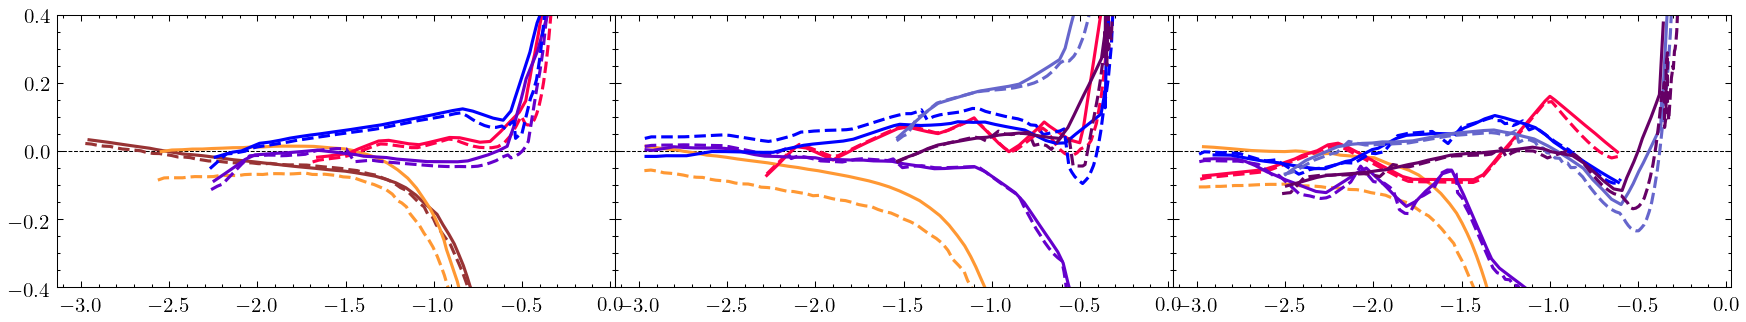

In [208]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=[4.8*3,4.8*.5], dpi=150)
fig5_plot(12, ax1, ratioFlag=True)
fig5_plot(13, ax2, ratioFlag=True)
fig5_plot(14, ax3, ratioFlag=True)
ax1.set_ylim(-0.4,.4)
ax1.axhline(0, ls='--', c='k', zorder=-1, lw=.5)
ax2.axhline(0, ls='--', c='k', zorder=-1, lw=.5)
ax3.axhline(0, ls='--', c='k', zorder=-1, lw=.5)

# Chi<sup>2</sup> fitting

In [126]:
# rdict = {12:(-0.6,-0.4), 13:(-1.9,-0.4), 14:(-2.8,-0.6), 'ALL':(-0.8,-0.5)}
alpha=0.8

In [12]:
ReducedChi2dict_SV0 = ReducedChi2dict_gen(cc_SV0, sh_SV0, centrals_mask_SV0, 'SV', 
                                      {12:(-1.3,-0.4), 13:(-1.9,-0.4), 14:(-2.8,-0.6), 'ALL':(-3.0, -0.4)}, 
                                      {12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
                                      {12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_SV0['M'].max()}, mlim=OBJECTMASSCUT['SV'])
pcolorplots(ReducedChi2dict_SV0, 
            M1dict={12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
            M2dict={12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_SV0['M'].max()})

SV 61500
SV 61500

SV 40628
SV 40628

SV 4797
SV 4797

SV 337
SV 337



In [13]:
ReducedChi2dict_SV1 = ReducedChi2dict_gen(cc_SV1, sh_SV1, centrals_mask_SV1, 'SV', 
                                      {12:(-1.3,-0.4), 13:(-1.9,-0.4), 14:(-2.8,-0.6), 'ALL':(-3.0, -0.4)}, 
                                      {12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
                                      {12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_SV1['M'].max()}, mlim=OBJECTMASSCUT['SV'])

SV 47554
SV 47554

SV 34592
SV 34592

SV 2418
SV 2418

SV 36
SV 36



In [14]:
ReducedChi2dict_SVavg = {k:((ReducedChi2dict_SV0[k]+ReducedChi2dict_SV1[k])/2.0) for k in ReducedChi2dict_SV0.keys()}

SV 40628
12
SV 40628

SV 4797
12
SV 4797

SV 337
17
SV 337



Text(0,0.5,'$\\log \\left[ \\mathrm{d}n/\\mathrm{d} \\log(m/M) \\right]$')

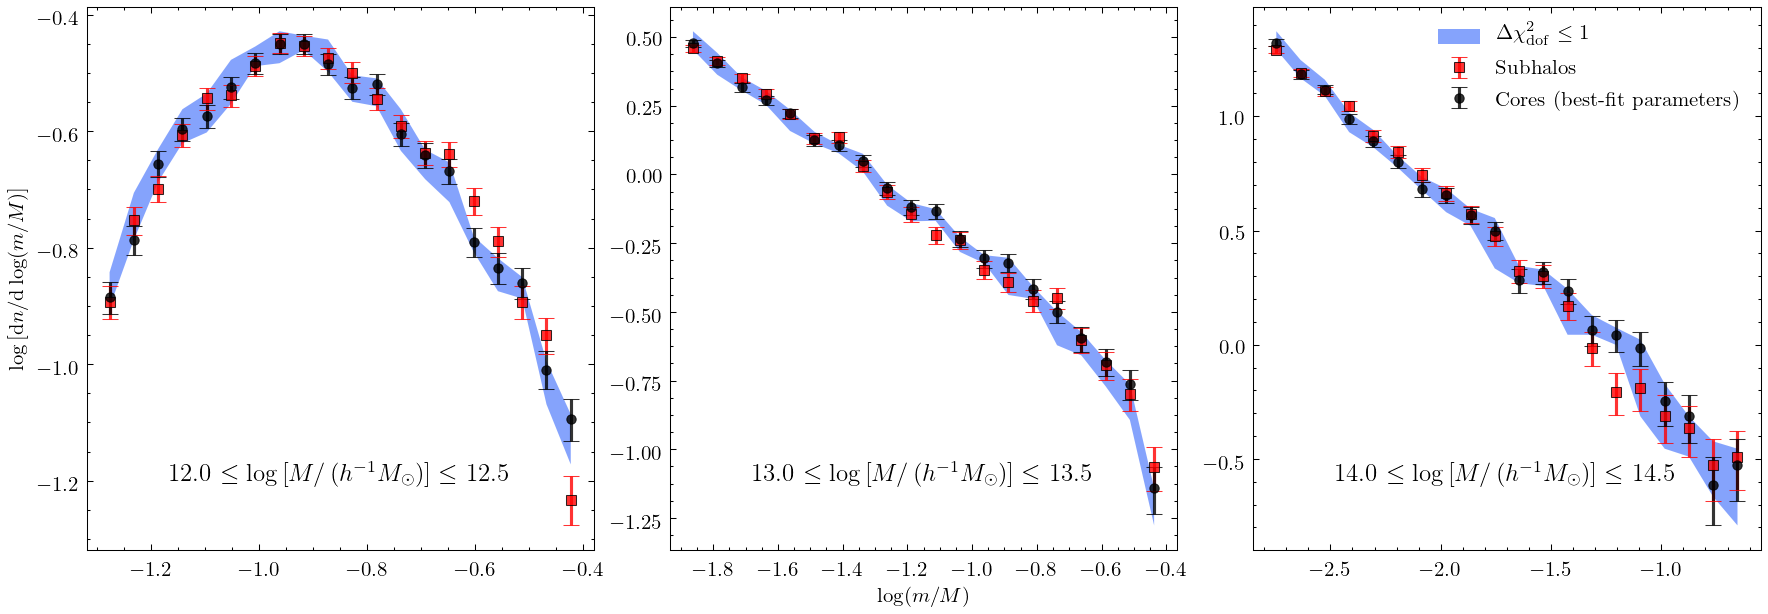

In [34]:
bins = 20
alpha = .8
label = 'SV'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False, gridspec_kw={'hspace': 0, 'wspace': .15}, figsize=[4.8*3,4.8*1], dpi=150)
for Mlabel, ax in zip( (12, 13, 14), (ax1, ax2, ax3) ):
    ReducedChi2 = ReducedChi2dict[Mlabel]
    
    M1, M2 = M1dict[Mlabel], M2dict[Mlabel]
    r = rdict[Mlabel]
    
    x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh = subhalo_plot(sh, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label])
    
    Avals, zvals = np.unravel_index( np.flatnonzero(mask_ReducedChi2_gen(ReducedChi2)), ReducedChi2.shape )
    best_ys = np.zeros((len(Avals), bins), dtype=np.float64)
    print len(Avals)
    for i, (A, zeta) in enumerate(zip(A_arr[Avals], zeta_arr[zvals])):
        _, y, _, _, _ = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=A, zeta=zeta, verbose=False)
        best_ys[i] = y
    
    Abfi, zetabfi = np.unravel_index(ReducedChi2.argmin(), ReducedChi2.shape)
    Abf, zetabf =  A_arr[Abfi], zeta_arr[zetabfi]
    x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=Abf, zeta=zetabf, verbose=True)
    assert nH_cores==nH_sh
    
    ax.fill_between(x, np.amin(best_ys, axis=0), np.amax(best_ys, axis=0), label=r'$\Delta \chi^2_{\mathrm{dof}} \le 1$', alpha=0.5)
    errorbar(ax, x_sh, y_sh, yerr=yerr_log_sh, label='Subhalos', c='r', alpha=alpha, marker='s')
    errorbar(ax, x, y, yerr=yerr_log, label='Cores (best-fit parameters)', c='k', alpha=alpha )
    print ''
    ax.set_title(r'{} $\le \log \left[ M / \left(h^{{-1}}M_\odot \right) \right] \le$ {}'.format(np.log10(M1), np.log10(M2)), y=0.1, x=0.5)

ax3.legend(loc=1)
ax2.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    
# plt.savefig('Paper2Figs/1sigma_z0.pdf')

SV 474
SV 474
SV 474
(-2.0337499737739564, -0.4662500262260437)


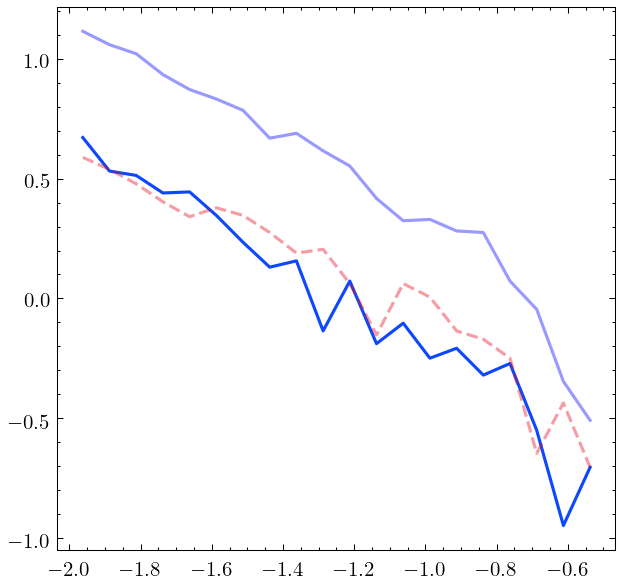

In [91]:
#testing: determine range
M1, M2 = 10**13.2, 10**13.3
r=(-2,-0.5)
bins = 20
alpha = .8
label = 'SV'

x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, bin_mask_sh_100 = subhalo_plot(sh, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], returnMask=True)
plt.plot(x_sh, y_sh, label='subhalos 100mp')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=0.4, zeta=0.3)
plt.plot(x, y, 'b-', alpha=0.4, label='cores 1')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=0.9, zeta=0.001)
plt.plot(x, y, alpha=0.4, label='cores 100mp')

print plt.xlim()
# plt.axvline(-2.)

SV 40628
SV 40628
SV 40628
SV 40628
SV 40628
SV 40628
SV 40628
1.9446791e+12
1.8971367e+12


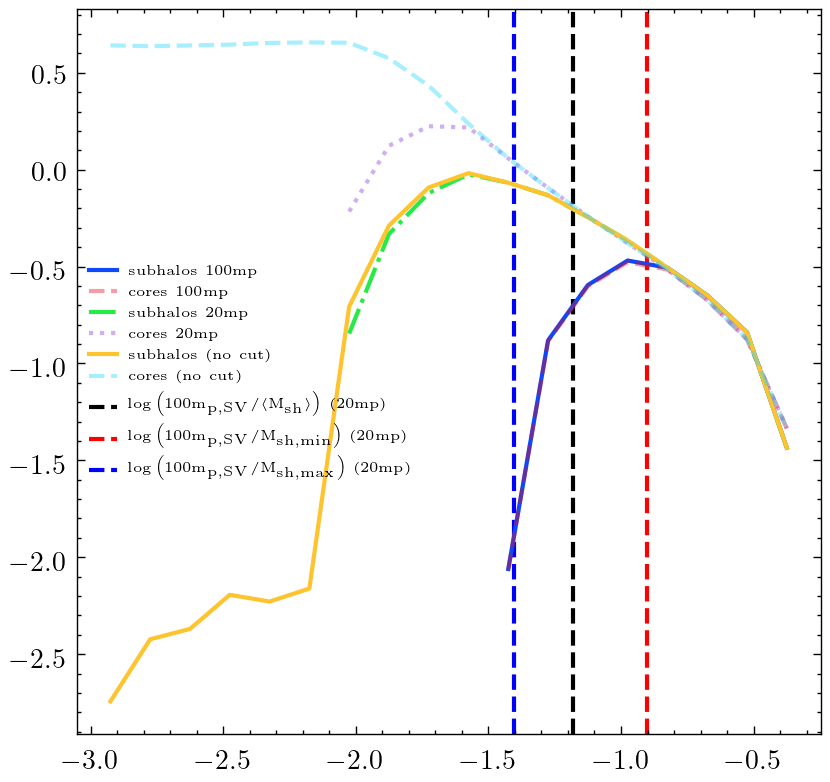

In [62]:
#testing: determine range
M1, M2 = 10**12.0, 10**12.5
r=(-3.,0)#(-0.8,-0.5)#(-0.6,-0.4)
bins = 20
alpha = .8
label = 'SV'
plt.figure(dpi=200)
x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, bin_mask_sh_100 = subhalo_plot(sh, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], returnMask=True)
plt.plot(x_sh, y_sh, label='subhalos 100mp')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=0.4, zeta=0.3)
# plt.plot(x, y, '-', alpha=0.4, label='cores 1')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=0.9, zeta=0.001)
plt.plot(x, y, alpha=0.4, label='cores 100mp')

x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, bin_mask_sh_20 = subhalo_plot(sh, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], returnMask=True)
plt.plot(x_sh, y_sh, label='subhalos 20mp')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=SUBHALOMINMASS[label], A=0.9, zeta=0.001)
plt.plot(x, y, alpha=0.4, label='cores 20mp')

x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh = subhalo_plot(sh, M1, M2, label, bins, r, mlim=0)
plt.plot(x_sh, y_sh, label='subhalos (no cut)')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=0, A=0.9, zeta=0.001)
plt.plot(x, y, alpha=0.4, label='cores (no cut)')

# plt.axvline(-3.0, label='Fitting range')
# plt.axvline(-0.4)

# plt.axvline(  np.log10(100.*PARTICLEMASS[label]/np.mean(sh['M'][bin_mask_sh_100])), ymax=1., ls='--', c='r', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}/\langle M_{sh} \rangle}\right)$ (100mp)' )
plt.axvline(  np.log10(100*PARTICLEMASS[label]/np.mean(sh['M'][bin_mask_sh_20])), ymax=1., c='k', ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}/\langle M_{sh} \rangle}\right)$ (20mp)', zorder=0 )

plt.axvline(  np.log10(100*PARTICLEMASS[label]/np.min(sh['M'][bin_mask_sh_20])), ymax=1., c='r', ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}/ M_{sh, min} }\right)$ (20mp)', zorder=0 )
plt.axvline(  np.log10(100*PARTICLEMASS[label]/np.max(sh['M'][bin_mask_sh_20])), ymax=1., c='b', ls='--', label=r'$\log \left(\mathrm{100m_{p,'+label+ r'}/M_{sh, max} }\right)$ (20mp)', zorder=0)

# plt.axvline(  np.log10(20.*PARTICLEMASS[label]/np.mean(sh['M'][bin_mask_sh_100])), ymax=1., ls='--', c='r', label=r'$\log \left(\mathrm{20m_{p,'+label+ r'}/\langle M_{sh} \rangle}\right)$ (100mp)' )
# plt.axvline(  np.log10(20.*PARTICLEMASS[label]/np.mean(sh['M'][bin_mask_sh_20])), ymax=1., ls='--', label=r'$\log \left(\mathrm{20m_{p,'+label+ r'}/\langle M_{sh} \rangle}\right)$ (20mp)',zorder=0)

print np.format_float_scientific( np.mean(sh['M'][bin_mask_sh_100]) )
print np.format_float_scientific( np.mean(sh['M'][bin_mask_sh_20]) )
        
plt.legend(fontsize=5)
# plt.axvline(-0.9)
# plt.axvline(-1.2)



## z=1 HM fitting

HM 33020
HM 33020

HM 2368
HM 2368

HM 21
HM 21

HM 45394
HM 45394

A 1.7 zeta 0.275
12.0 12.5
6.348674000180215 4807.801478138268

A 2.2 zeta 0.3
13.0 13.5
6.8980966639947505 1823.6431314299984

A 0.9 zeta 0.07
14.0 14.5
0.9877083910909339 172.27106545579355

A 1.9 zeta 0.3
12.0 14.577735
12.882110053305972 8274.739556584587



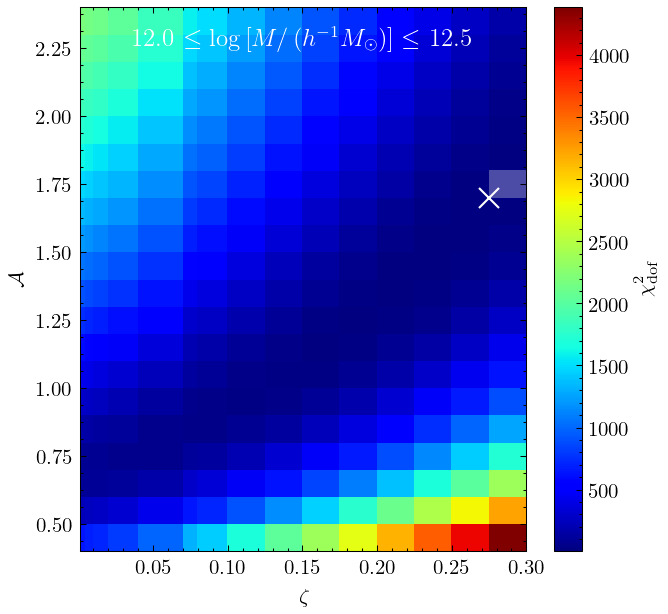

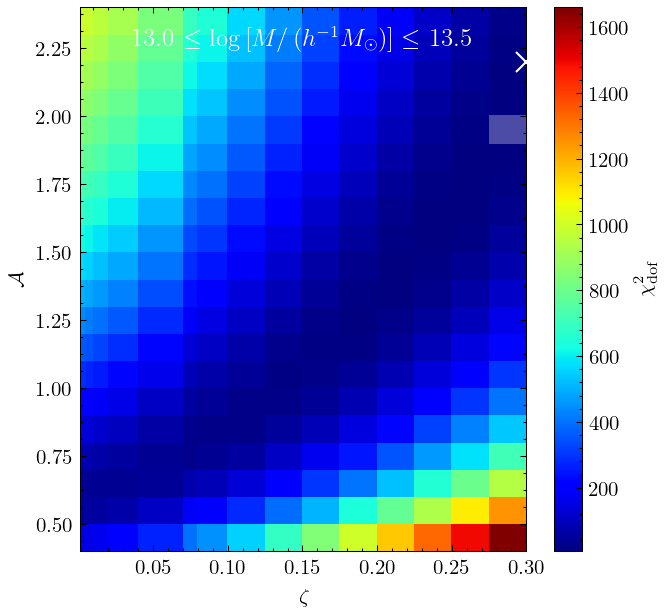

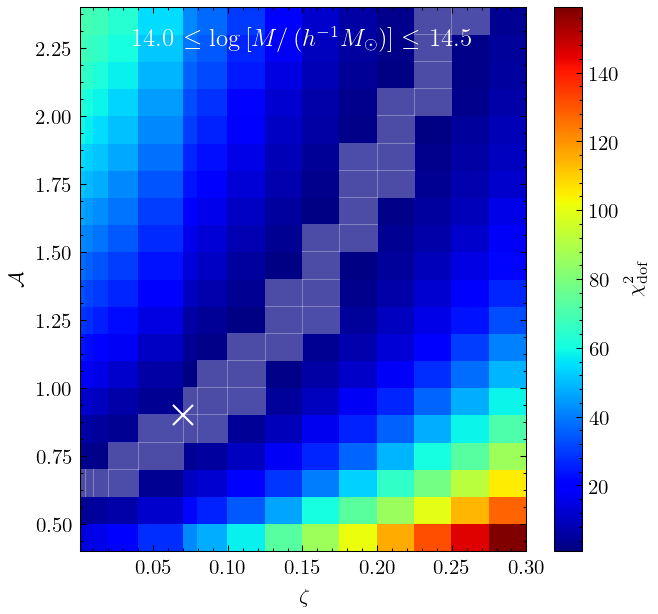

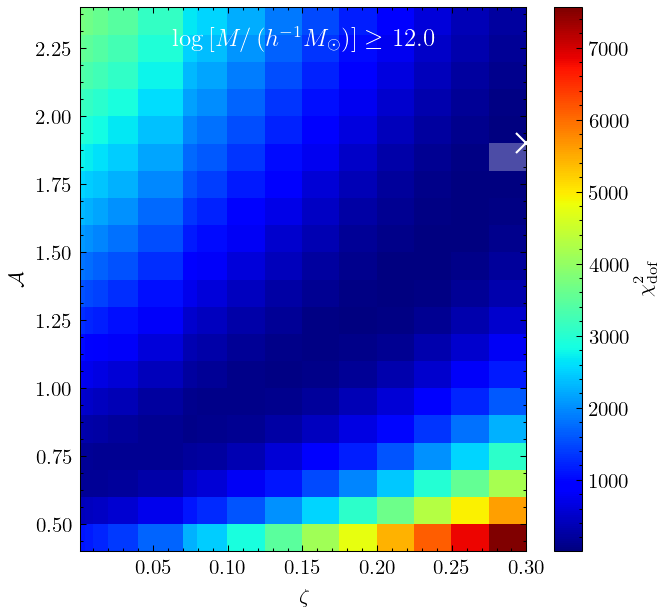

In [24]:
ReducedChi2dict_HM1 = ReducedChi2dict_gen(cc_HM1, sh_HM1, centrals_mask_HM1, 'HM', 
                                      {12:(-2.2,-0.6), 13:(-3.0,-0.6), 14:(-4.0,-0.6), 'ALL':(-2.3,-0.6)}, #z=0 HM fitting 
                                      {12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
                                      {12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_HM1['M'].max()}, mlim=OBJECTMASSCUT['HM'])
pcolorplots(ReducedChi2dict_HM1,
            M1dict={12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
            M2dict={12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_HM1['M'].max()})

HM 39505
HM 39505

HM 4738
HM 4738

HM 348
HM 348

HM 59759
HM 59759

A 0.8 zeta 0.01
12.0 12.5
2.1918013196558483 6749.011395611575

A 0.8 zeta 0.01
13.0 13.5
5.008949183657138 4581.563918089906

A 0.8 zeta 0.001
14.0 14.5
8.897495929082156 3529.1384373394767

A 0.8 zeta 0.01
12.0 15.193961
3.8880778082855283 12830.820356818338



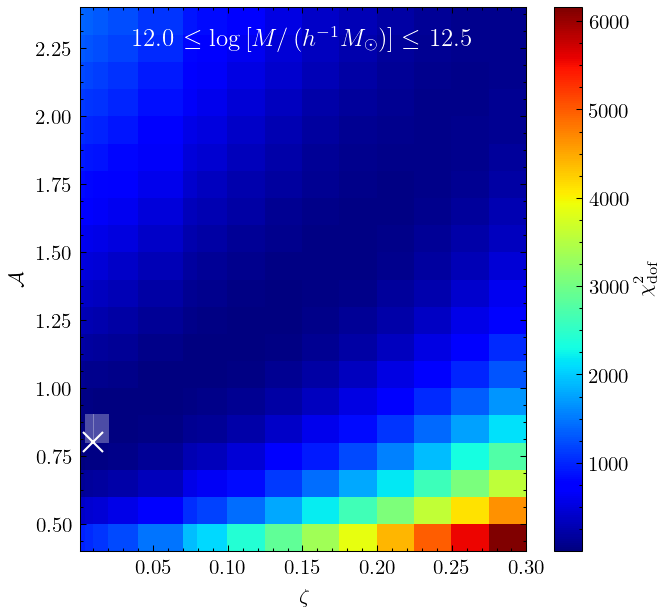

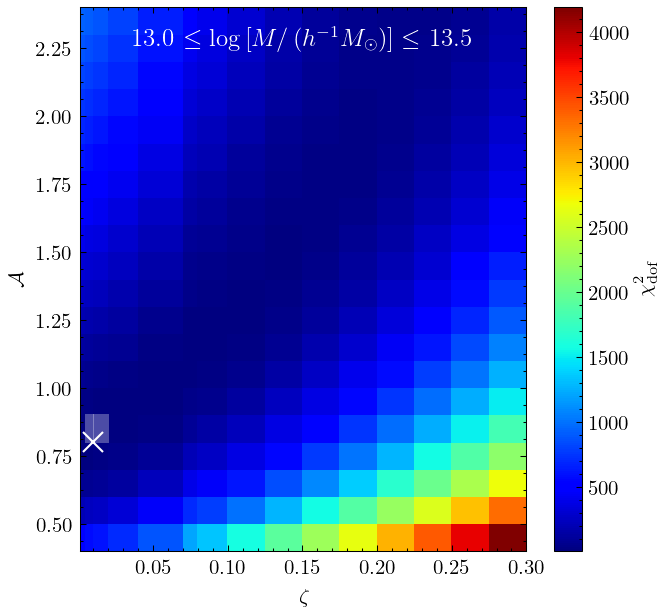

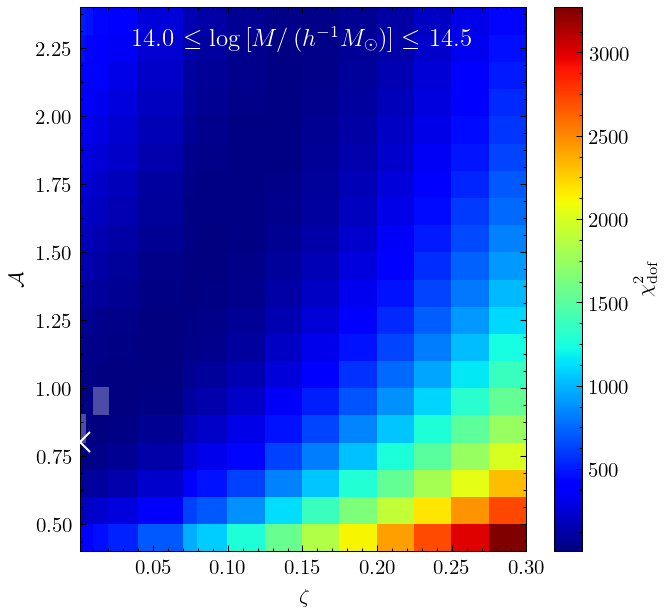

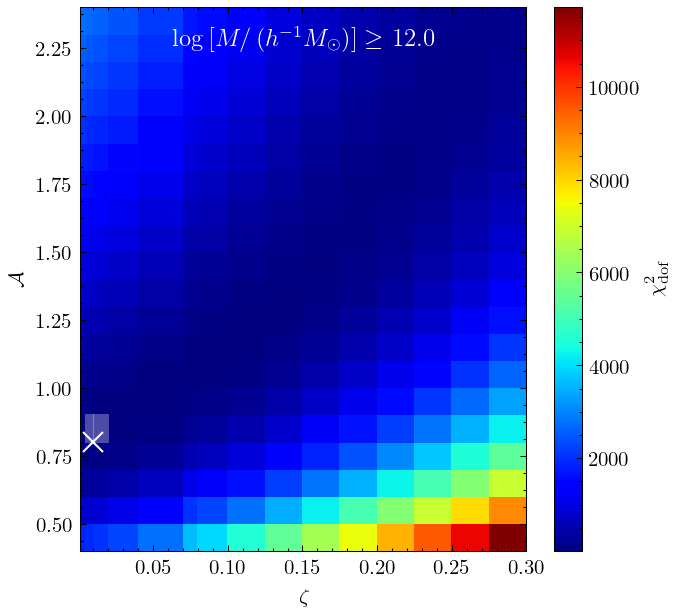

In [21]:
ReducedChi2dict_HM0 = ReducedChi2dict_gen(cc_HM0, sh_HM0, centrals_mask_HM0, 'HM', 
                                      {12:(-2.2,-0.6), 13:(-3.0,-0.6), 14:(-4.0,-0.6), 'ALL':(-2.3,-0.6)}, #z=0 HM fitting 
                                      {12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
                                      {12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_HM0['M'].max()}, mlim=OBJECTMASSCUT['HM'])
pcolorplots(ReducedChi2dict_HM0, 
            M1dict={12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
            M2dict={12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_HM0['M'].max()})

A 1.0 zeta 0.1
12.0 12.5
46.55424115524989 5778.406436874921

A 0.7 zeta 0.01
13.0 13.5
46.4591652108617 3202.603524759952

A 0.8 zeta 0.001
14.0 14.5
7.963353079279413 1850.7047513976352

A 0.9 zeta 0.07
12.0 15.193961
94.26709089253171 10552.779956701463



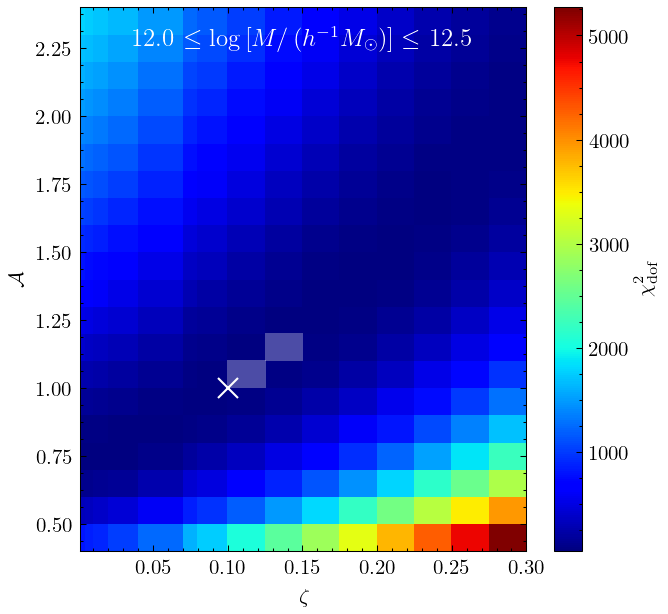

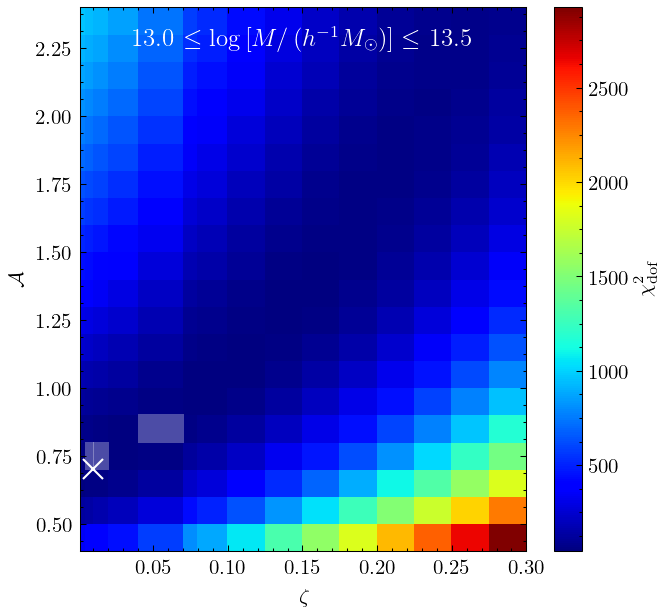

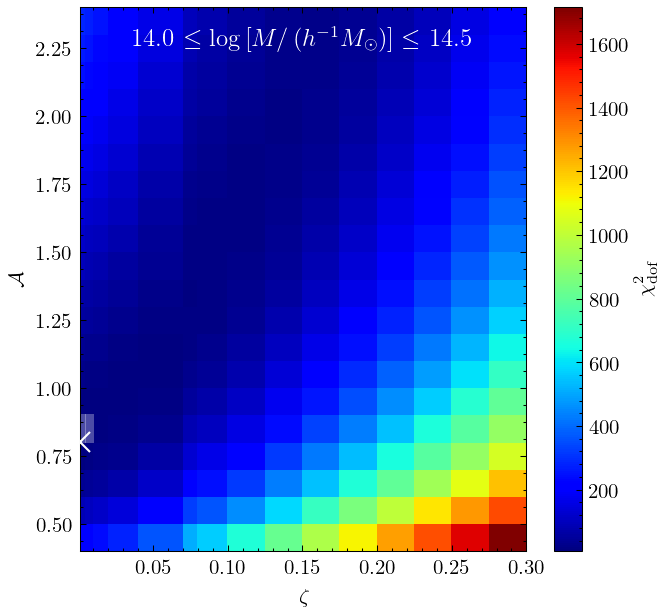

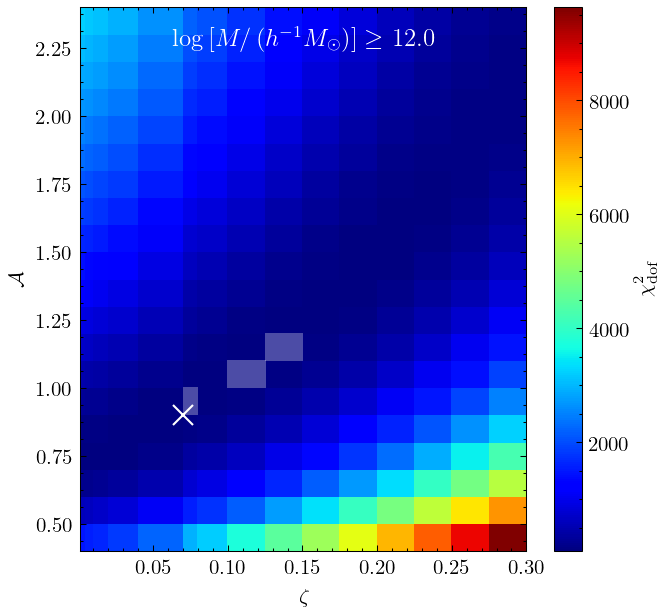

In [26]:
ReducedChi2dict_HMavg = {k:((ReducedChi2dict_HM0[k]+ReducedChi2dict_HM1[k])/2.0) for k in ReducedChi2dict_HM0.keys()}
pcolorplots(ReducedChi2dict_HMavg, 
            M1dict={12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
            M2dict={12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_HM0['M'].max()})

HM 45394
HM 45394
HM 45394
HM 45394
(-2.3382499277591706, -0.5617500483989716)


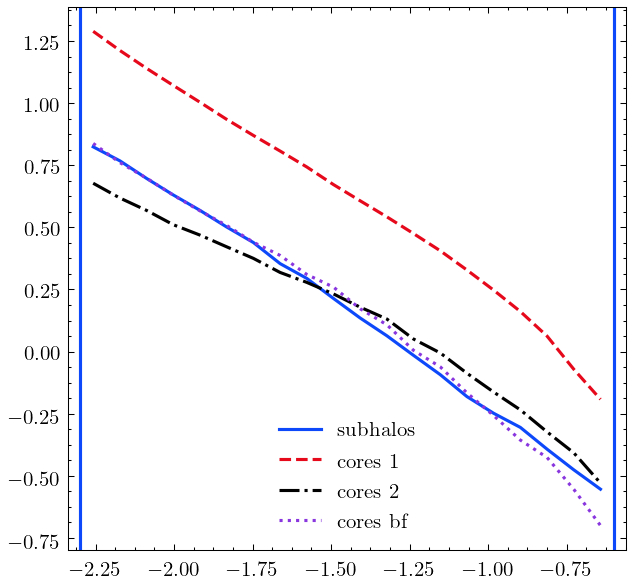

In [75]:
#testing: determine range
M1, M2 = 10**12.0,cc['M'].max()#10**14.5
r=rdict['ALL']
bins = 20
label = 'HM'

x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh, bin_mask_sh_100 = subhalo_plot(sh, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], returnMask=True)
plt.plot(x_sh, y_sh, label='subhalos')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=0.4, zeta=0.3)
plt.plot(x, y, label='cores 1')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=0.8, zeta=0.01)
plt.plot(x, y, 'k', label='cores 2')

x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=OBJECTMASSCUT[label], A=1.9, zeta=0.3)
plt.plot(x, y, label='cores bf')

plt.legend()
print plt.xlim()
plt.axvline(-2.3)
plt.axvline(-0.6)

# Fitting test

HM 33020
HM 33020

HM 2368
HM 2368

HM 21
HM 21

HM 45394
HM 45394

A 1.9 zeta 0.3
12.0 12.5
3.4653480635823346 4490.073528303116

A 1.1 zeta 0.15
13.0 13.5
10.296661040083178 2696.942661229412

A 0.6 zeta 0.001
14.0 14.5
1.4848460941775288 266.26978990686933

A 1.7 zeta 0.25
12.0 14.577735
16.86298170168108 12705.712561657232



/home/isultan/.local/lib/python2.7/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/isultan/.local/lib/python2.7/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


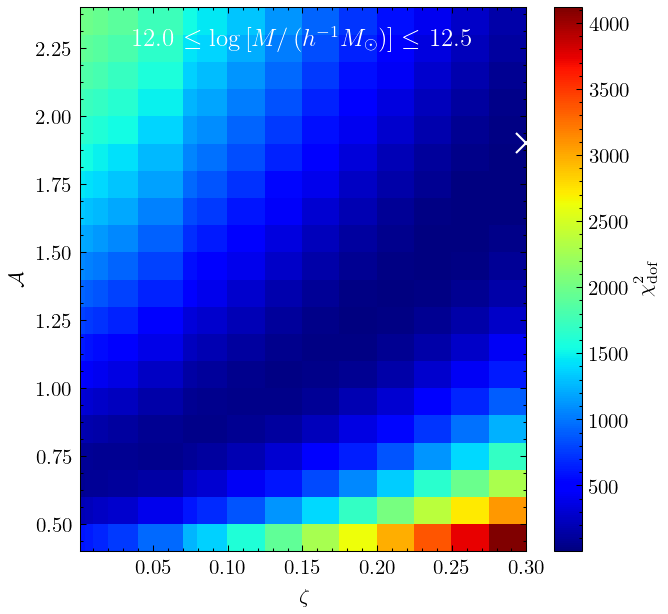

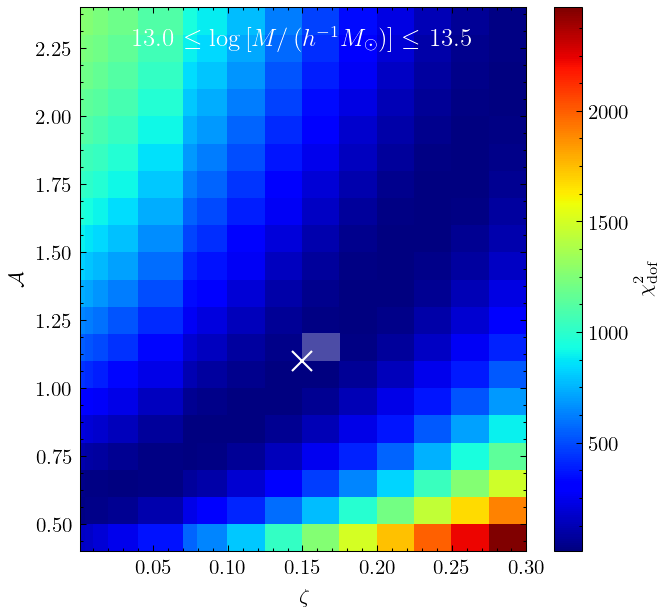

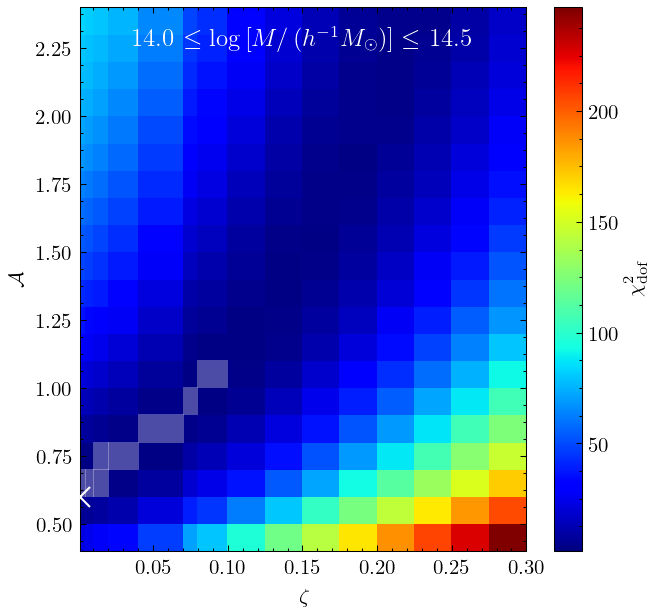

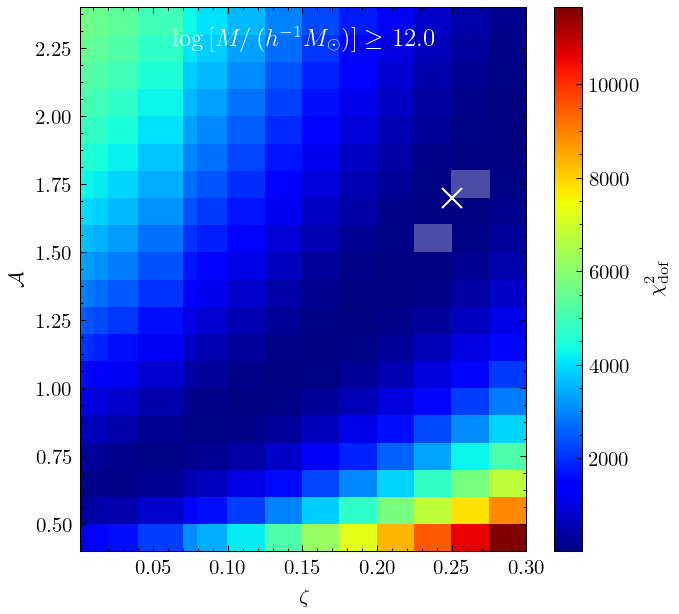

In [23]:
ReducedChi2dict_HM1_mplot_dlog = ReducedChi2dict_gen(cc_HM1, sh_HM1, centrals_mask_HM1, 'HM', 
                                          {12:(10.0, 11.4), 13:(10.0, 11.8), 14:(10.0, 11.8), 'ALL':(10.0, 11.8)}, 
                                          {12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
                                          {12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_HM1['M'].max()}, mlim=0, mplot=True, dlog=True)
pcolorplots(ReducedChi2dict_HM1_mplot_dlog, 
            M1dict={12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}, 
            M2dict={12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc_HM1['M'].max()})

HM 39505
HM 39505
HM 39505
HM 39505

HM 4738
HM 4738
HM 4738
HM 4738

HM 348
HM 348
HM 348
HM 348



Text(0,0.5,'$\\log \\left[ \\mathrm{d}n/\\mathrm{d} \\log(m/M) \\right]$')

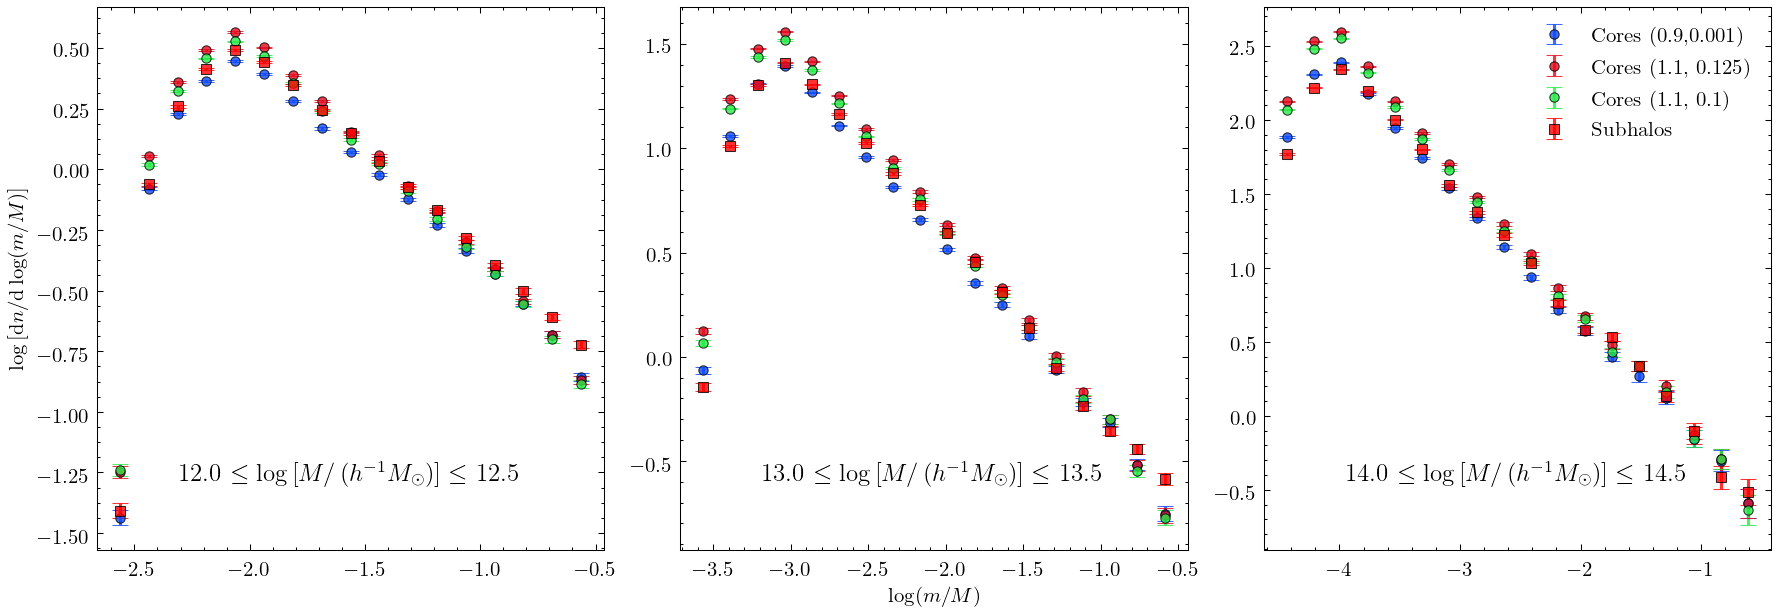

In [99]:
bins = 20
alpha = .8
label = 'HM'

cc = cc_HM0
sh = sh_HM0
centrals_mask = centrals_mask_HM0

M1dict={12:10**12.0, 13:10**13.0, 14:10**14.0, 'ALL':10**12.0}
M2dict={12:10**12.5, 13:10**13.5, 14:10**14.5, 'ALL':cc['M'].max()}
# rdict = { 
#     12:(-1.3,-0.4), 
#     13:(-1.9,-0.4), 
#     14:(-2.8,-0.6)
# }

rdict = { 
    12:(-3.0,-0.5), 
    13:(-4.0,-0.5), 
    14:(-5.0,-0.5)
}

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, sharey=False, gridspec_kw={'hspace': 0, 'wspace': .15}, figsize=[4.8*3,4.8*1], dpi=150)
for Mlabel, ax in zip( (12, 13, 14), (ax1, ax2, ax3) ):
    M1, M2 = M1dict[Mlabel], M2dict[Mlabel]
    r = rdict[Mlabel]
    
    x_sh, y_sh, yerr_sh, yerr_log_sh, nH_sh = subhalo_plot(sh, M1, M2, label, bins, r, mlim=2*OBJECTMASSCUT[label])
    
    Abf, zetabf =  0.9, 0.001
    x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=2*OBJECTMASSCUT[label], A=Abf, zeta=zetabf, verbose=True)
    errorbar(ax, x, y, yerr=yerr_log, label='Cores (0.9,0.001)', alpha=alpha )
    
    Abf, zetabf =  1.1, 0.125
    x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=2*OBJECTMASSCUT[label], A=Abf, zeta=zetabf, verbose=True)
    errorbar(ax, x, y, yerr=yerr_log, label='Cores (1.1, 0.125)', alpha=alpha )
    
    Abf, zetabf =  1.1, 0.1
    x, y, yerr, yerr_log, nH_cores = cores_plot(cc, centrals_mask, M1, M2, label, bins, r, mlim=2*OBJECTMASSCUT[label], A=Abf, zeta=zetabf, verbose=True)
    errorbar(ax, x, y, yerr=yerr_log, label='Cores (1.1, 0.1)', alpha=alpha )
    
    
    
    assert nH_cores==nH_sh
    
    errorbar(ax, x_sh, y_sh, yerr=yerr_log_sh, label='Subhalos', c='r', alpha=alpha, marker='s')
    
    print ''
    ax.set_title(r'{} $\le \log \left[ M / \left(h^{{-1}}M_\odot \right) \right] \le$ {}'.format(np.log10(M1), np.log10(M2)), y=0.1, x=0.5)

ax3.legend(loc=1)
ax2.set_xlabel(r'$\log(m/M)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}n/\mathrm{d} \log(m/M) \right]$')
    
# plt.savefig('Paper2Figs/1sigma_z0.pdf')

# Subhalo:Core matching

In [20]:
def subhalo_core_match(M1, M2, cc, centrals_mask, sh, step, mlim=OBJECTMASSCUT['SV'], SHMLM=SHMLM_SV, A=0.9, zeta=0.001, s1=False, mostMassiveCore=False):
    sh['rvir'] = SHMLM.getRvir(sh['subhalo_mass'], SHMLM.step2z[step])
    subhalo_mean_x = periodic_bcs(sh['subhalo_mean_x'], sh['X'], SHMLM.BOXSIZE)
    subhalo_mean_y = periodic_bcs(sh['subhalo_mean_y'], sh['Y'], SHMLM.BOXSIZE)
    subhalo_mean_z = periodic_bcs(sh['subhalo_mean_z'], sh['Z'], SHMLM.BOXSIZE)

    cores_x = periodic_bcs(cc['x'], cc['X'], SHMLM.BOXSIZE)
    cores_y = periodic_bcs(cc['y'], cc['Y'], SHMLM.BOXSIZE)
    cores_z = periodic_bcs(cc['z'], cc['Z'], SHMLM.BOXSIZE)

    bin_mask_sh = (sh['subhalo_tag']!=0)&(M1 <= sh['M'])&(sh['M'] <= M2)&(sh['subhalo_mass']>mlim)
    nH_sh = len(np.unique( sh['fof_halo_tag'][(M1 <= sh['M'])&(sh['M'] <= M2)] ))

    sh_arr = np.vstack((subhalo_mean_x[bin_mask_sh], subhalo_mean_y[bin_mask_sh], subhalo_mean_z[bin_mask_sh])).T
    distance_upper_bound = 2. * sh['rvir'][bin_mask_sh]

    bin_mask_cores = (~centrals_mask)&(M1 <= cc['M'])&(cc['M'] <= M2)&(cc[m_evolved_col(A, zeta)]>mlim)
    if s1:
        bin_mask_cores = bin_mask_cores&(cc['host_core']==cc['CORETAG'])
    fht_fof = (cc['fof_halo_tag']<0)*np.bitwise_and(cc['fof_halo_tag']*-1, 0xffffffffffff) + (cc['fof_halo_tag']>=0)*cc['fof_halo_tag']
    nH_cores = len(np.unique( fht_fof[centrals_mask&(M1 <= cc['M'])&(cc['M'] <= M2)] ))
    assert nH_cores == nH_sh

    cores_tree = spatial.cKDTree( np.vstack((cores_x[bin_mask_cores], cores_y[bin_mask_cores], cores_z[bin_mask_cores])).T )
    
    if mostMassiveCore:
        iarr, carr = [], []
        for i in range(len(distance_upper_bound)):
            qres = cores_tree.query_ball_point(sh_arr[i], r=distance_upper_bound[i])
            if len(qres)>0:
                idxmax = qres[ np.argmax(cc[m_evolved_col(A, zeta)][bin_mask_cores][qres]) ]
                iarr.append(i)
                carr.append(idxmax)
        percentexists = len(iarr)/np.sum(bin_mask_sh)*100
        print '{}% of masked subhalos have at least 1 core within their search radius.'.format(percentexists)
        matched_mask_cores = np.flatnonzero(bin_mask_cores)[carr]
        matched_mask_sh = np.flatnonzero(bin_mask_sh)[iarr]
    else:
        dist, idx = [], []
        for i in range(len(distance_upper_bound)):
            dv, iv = cores_tree.query(sh_arr[i], k=2, distance_upper_bound=distance_upper_bound[i])
            dist.append(dv)
            idx.append(iv)
        dist = np.array(dist)
        idx = np.array(idx)

        f1, f2 = (dist != np.inf).T
        fmask = f1^f2

        percentmatch = np.sum(fmask)/np.sum(bin_mask_sh)*100
        f1i = f1[np.invert(fmask)]
        percentmany = np.sum(f1i)/len(f1i)*100
        percentnone = np.sum(np.invert(f1i))/len(f1i)*100
        print '{}% of masked subhalos have 1:1 core match. Of the unmatched subhalos, {}% have mutliple cores and {}% have no core.'.format(percentmatch, percentmany, percentnone)

        matched_mask_cores = np.flatnonzero(bin_mask_cores)[idx[:,0][fmask]]
        matched_mask_sh = np.flatnonzero(bin_mask_sh)[fmask]
    
    matched_m_cores = cc[m_evolved_col(A, zeta)][matched_mask_cores]
    matched_M_cores = cc['M'][matched_mask_cores]
    matched_ifhm_cores = cc['infall_fof_halo_mass'][matched_mask_cores]
    
    matched_m_sh = sh['subhalo_mass'][matched_mask_sh]
    matched_M_sh = sh['M'][matched_mask_sh]
    
#     assert np.array_equal(matched_M_cores, matched_M_sh)
    
    return (matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh), matched_mask_cores, matched_mask_sh

In [21]:
for logM1 in (12, 13, 14):
    M1, M2 = 10**logM1, 10**(logM1+0.5)
    _, _, matched_mask_cores, matched_mask_sh = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499)
    _, _, matched_mask_cores_s1, matched_mask_sh_s1 = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, s1=True)
    _, _, matched_mask_cores_mmc, matched_mask_sh_mmc = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, mostMassiveCore=True)
    
    assert len(matched_mask_sh)==len(np.unique(matched_mask_sh))
    assert len(matched_mask_sh_s1)==len(np.unique(matched_mask_sh_s1))
    assert len(matched_mask_sh_mmc)==len(np.unique(matched_mask_sh_mmc))
    
    print 'ALL CORES UNIQUE', len(np.unique(matched_mask_cores))/len(matched_mask_cores)*100
    print 'S1  CORES UNIQUE', len(np.unique(matched_mask_cores_s1))/len(matched_mask_cores_s1)*100
    print 'MMC  CORES UNIQUE', len(np.unique(matched_mask_cores_mmc))/len(matched_mask_cores_mmc)*100
    
    print '% OF SUBHALOS (ALL CORES) FOUND IN SUBHALOS (S1 CORES)', len(np.intersect1d(matched_mask_sh, matched_mask_sh_s1))/len(matched_mask_sh)*100
    
#     assert np.isin(matched_mask_cores, matched_mask_cores_s1).all()
    
    print ''

68.7189335743% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 17.0097508126% have mutliple cores and 82.9902491874% have no core.
69.3741527338% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 15.0129103652% have mutliple cores and 84.9870896348% have no core.
74.0397650249% of masked subhalos have at least 1 core within their search radius.
ALL CORES UNIQUE 97.583429229
S1  CORES UNIQUE 97.2154372252
MMC  CORES UNIQUE 95.5599633811
% OF SUBHALOS (ALL CORES) FOUND IN SUBHALOS (S1 CORES) 99.9013644583

52.9609929078% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 56.6339992461% have mutliple cores and 43.3660007539% have no core.
55.3723404255% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 50.4966229638% have mutliple cores and 49.5033770362% have no core.
79.6010638298% of masked subhalos have at least 1 core within their search radius.
ALL CORES UNIQUE 94.8610646133
S1  CORES UNIQUE 92.8113992955
MMC  CORE

74.0397650249% of masked subhalos have at least 1 core within their search radius.
79.6010638298% of masked subhalos have at least 1 core within their search radius.
82.1674732365% of masked subhalos have at least 1 core within their search radius.


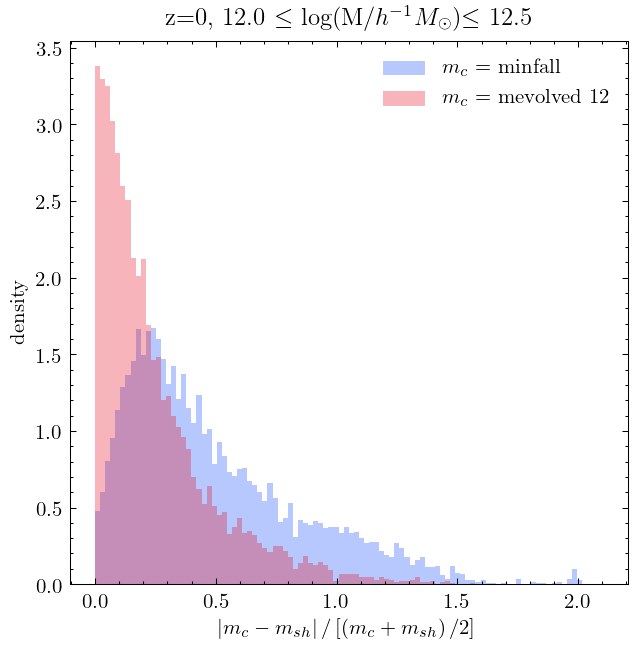

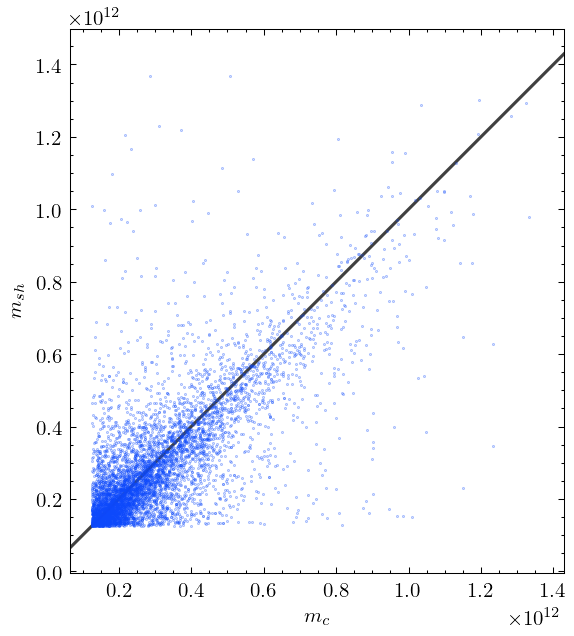

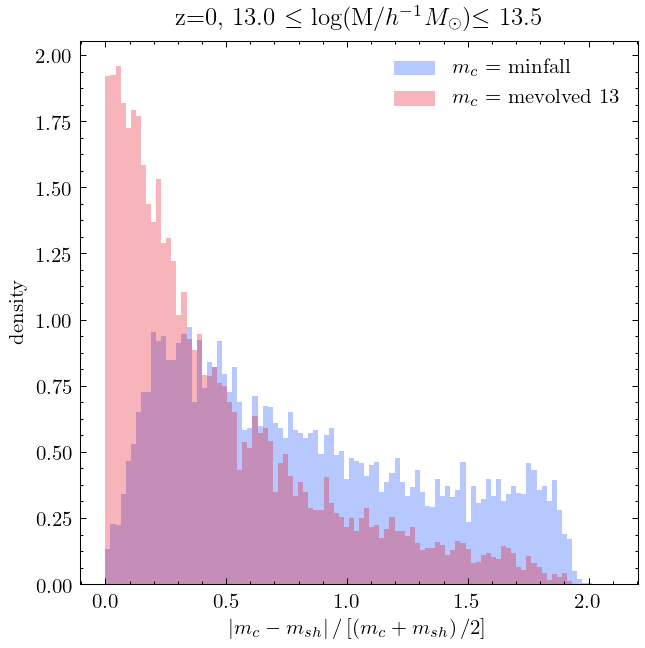

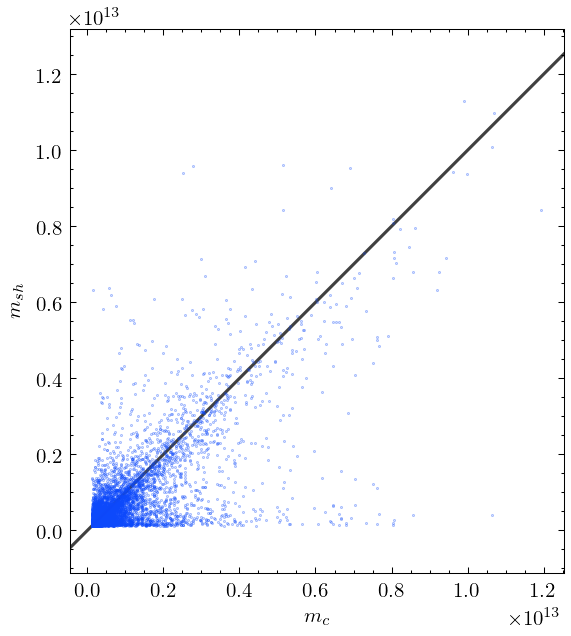

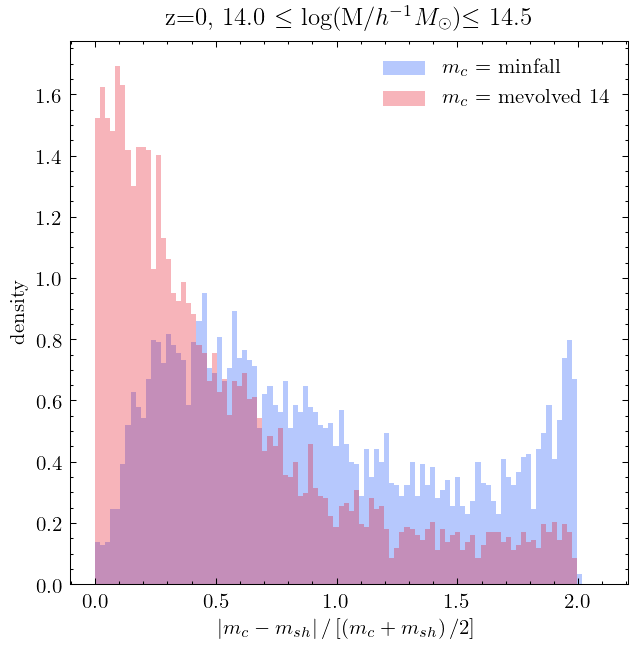

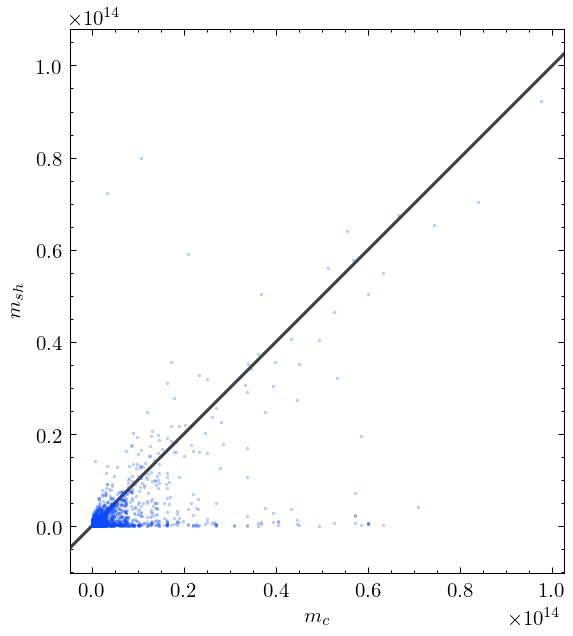

In [22]:
for logM1, alpha in zip( (12, 13, 14), (.3, .3, .3) ):
    M1, M2 = 10**logM1, 10**(logM1+0.5)
    (matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh), _, _ = subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499, mostMassiveCore=True)
    #(matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh), _, _ = subhalo_core_match(M1, M2, cc_HM0, centrals_mask_HM0, sh_HM0, 499, mlim=OBJECTMASSCUT['HM'], SHMLM=SHMLM_HM, mostMassiveCore=True)
    
    bins = 100
    r = (0, 2.1)

    plt.figure()
    plt.hist(reldif(matched_ifhm_cores, matched_m_sh), range=r, bins=bins, alpha=alpha, label='$m_c=$ minfall', density=True);
    plt.hist(reldif(matched_m_cores, matched_m_sh), range=r, bins=bins, alpha=alpha, label='$m_c=$ mevolved '+str(logM1), density=True);
    plt.title( 'z=0, {} $\leq$ log(M/$h^{{-1}}M_\odot$)$\leq$ {}'.format(np.log10(M1),np.log10(M2)) )
    plt.xlabel(r'$\left|m_c-m_{sh}\right|/\left[\left(m_c+m_{sh}\right)/2\right]$')
    plt.ylabel('density')
    plt.legend()
    
    fig, ax = plt.subplots(1)
    ax.scatter(matched_m_cores, matched_m_sh, s=.1, alpha=0.5)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_xlabel('$m_c$')
    ax.set_ylabel('$m_{sh}$')

59.491787496% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 64.5516744689% have mutliple cores and 35.4483255311% have no core.
59.2946972644% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 20.4930564403% have mutliple cores and 79.5069435597% have no core.




/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract
/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


43.5177329034% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 80.8772720445% have mutliple cores and 19.1227279555% have no core.
41.4483381675% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 27.0505116128% have mutliple cores and 72.9494883872% have no core.




/home/isultan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


33.8504469564% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 85.4068354068% have mutliple cores and 14.5931645932% have no core.
36.2505757715% of masked subhalos have 1:1 core match. Of the unmatched subhalos, 24.5664739884% have mutliple cores and 75.4335260116% have no core.




Text(0,0.5,'ratio')

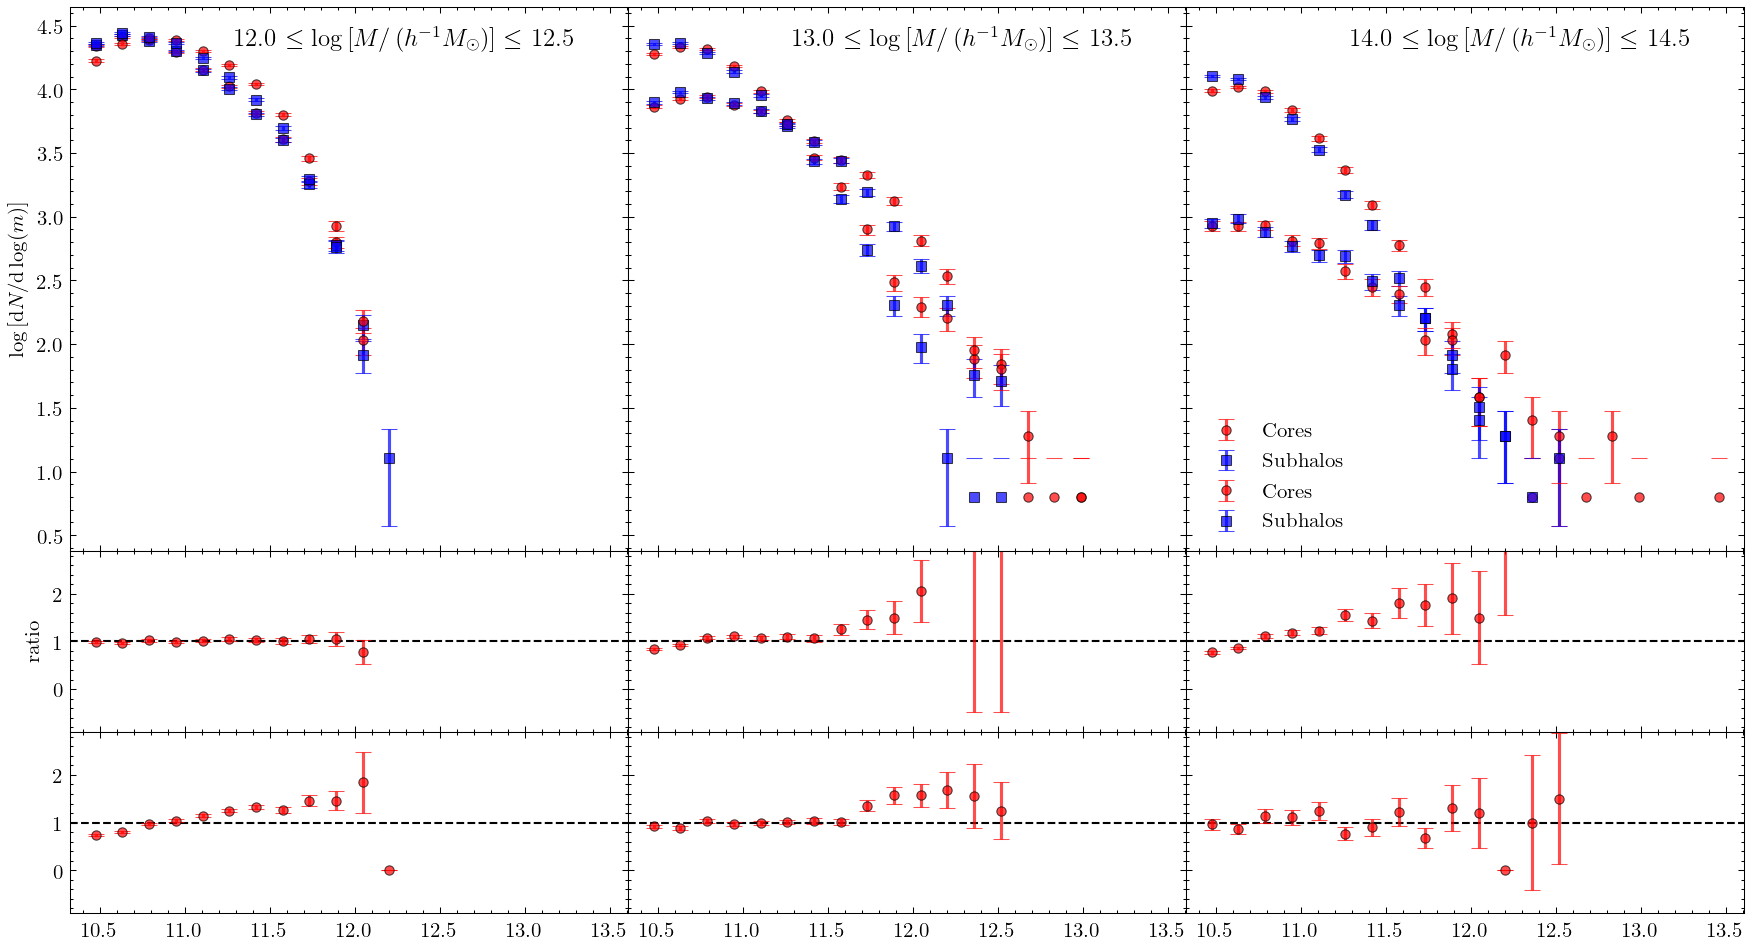

In [62]:
# r = (-4,-0.5)
r = (np.log10(SUBHALOMINMASS['SV']),13.539756)
bins = 20
alpha = .7

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex='all', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0, 'height_ratios': [3, 1, 1]}, figsize=[4.8*3,4.8*5/3], dpi=150)
for logM1, ax, axr1, axr2 in zip((12, 13, 14), (ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)):
    ax.set_title(r'{} $\le \log \left[ M / \left(h^{{-1}}M_\odot \right) \right] \le$ {}'.format(logM1+0.0, logM1+0.5), y=0.9, x=0.6)
    M1, M2 = 10**logM1, 10**(logM1+0.5)
    label = str(logM1)

    for ((matched_m_cores, matched_M_cores, nH_cores, matched_ifhm_cores), (matched_m_sh, matched_M_sh, nH_sh)), axr in zip( (subhalo_core_match(M1, M2, cc_SV0, centrals_mask_SV0, sh_SV0, 499), subhalo_core_match(M1, M2, cc_SV1, centrals_mask_SV1, sh_SV1, 247)), (axr1, axr2) ):
        parr = matched_m_cores
        parr_sh = matched_m_sh

        x, y, yerr, yerr_log = hist(np.log10(parr), bins=bins, normed=True, plotFlag=False, range=r, normBinsize=True, normLogCnts=True, retEbars=True)
        errorbar(ax, x, y, yerr=yerr_log, label='Cores', marker='o', alpha=alpha, c='r')

        x_sh, y_sh, yerr_sh, yerr_log_sh = hist(np.log10(parr_sh), bins=bins, normed=True, plotFlag=False, range=r, normBinsize=True, normLogCnts=True, retEbars=True)
        errorbar(ax, x_sh, y_sh, yerr=yerr_log_sh, label='Subhalos', marker='s', alpha=alpha, c='b')

        print ''
        errorbar(axr, x, 10**(y-y_sh), yerr=nratioerr(10**y, yerr, 10**y_sh, yerr_sh), marker='o', c='r', alpha=alpha)
    
        axr.axhline(1, c='k',ls='--', lw=1, zorder=-1)
        #print axr.get_ylim()
        axr.set_ylim(-.9,2.9)
ax3.legend(loc=3)
ax5.set_xlabel(r'$\log(m)$')
ax1.set_ylabel(r'$\log \left[ \mathrm{d}N/\mathrm{d} \log(m) \right]$')
ax4.set_ylabel(r'ratio')
# plt.savefig('Paper2Figs/spatialmatching_SV_z0.pdf')